<a href="https://colab.research.google.com/github/aline-lessa/TrabalhoModMatIA/blob/main/ML_for_Bulk_Density_in_Wells.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning for Bulk Density in Petroleum Wells

This notebook applies machine learning techniques to predict bulk density in wells, comparing the results with **Gardner's equation**.

## Data
- 10 wells
- 6 petrophysical variables
- Evaporitic rocks removed

## Analyses
- Spearman correlation
- PCA
- Lasso

## Models
- `SVR`
- `Decision Tree`
- `Artificial Neural Network`


# **Conectando ao Google Drive e importando dados**

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
dataset_original = pd.read_excel('/content/drive/My Drive/IA/Trabalho Final/dataset/DadosDensDTCLitologia.xlsx')
dataset_original

Poço Prof. Medida DENSIDADE DT COMPRESSIONAL      Cota      TVD  \
0       POÇO09      2856,00      2,64           117,43  -2828,81  2854,81   
1       POÇO09      2856,15      2,35           115,93  -2828,96  2854,96   
2       POÇO09      2856,30      1,84           115,66  -2829,11  2855,11   
3       POÇO09      2856,46      1,78           116,73  -2829,27  2855,27   
4       POÇO09      2856,61      1,84           118,79  -2829,42  2855,42   
...        ...          ...       ...              ...       ...      ...   
152226  POÇO03      6025,13      2,60              NaN  -5953,53  5985,53   
152227  POÇO03      6025,29      2,59              NaN  -5953,69  5985,69   
152228  POÇO03      6025,44      2,56              NaN  -5953,84  5985,84   
152229  POÇO03      6025,59      2,54              NaN  -5953,99  5985,99   
152230  POÇO03      6025,74      2,54              NaN  -5954,14  5986,14   

       Litologia Interpretada (sistema)  
0                              FOLHELHO  
1                              FOLHELHO  
2                              FOLHELHO  
3                              FOLHELHO  
4                              FOLHELHO  
...                                 ...  
152226                          COQUINA  
152227                          COQUINA  
152228                          COQUINA  
152229                          COQUINA  
152230                          COQUINA  

[152231 rows x 7 columns]

Importando dados de LDA

In [ ]:
lda_df = pd.read_excel('/content/drive/My Drive/IA/Trabalho Final/dataset/DadosLDA.xlsx') #carrega arquivo com informações de LDA
print(lda_df)

     Poço Lâmina d'água
0  POÇO09       1888,00
1  POÇO08       1690,00
2  POÇO07       2001,00
3  POÇO10       2049,00
4  POÇO06       1818,00
5  POÇO04       1751,00
6  POÇO05       2062,04
7  POÇO01       2020,00
8  POÇO02       1929,00
9  POÇO03       2136,00


In [ ]:
dicionario_lda = dict(zip(lda_df['Poço'], lda_df["Lâmina d'água"])) #cria dicionário para mapeamento de LDA
print(dicionario_lda)

{'POÇO09': '1888,00', 'POÇO08': '1690,00', 'POÇO07': '2001,00', 'POÇO10': '2049,00', 'POÇO06': '1818,00', 'POÇO04': '1751,00', 'POÇO05': '2062,04', 'POÇO01': '2020,00', 'POÇO02': '1929,00', 'POÇO03': '2136,00'}


In [ ]:
dataset_original.loc[:,"Lâmina d'água"] = dataset_original["Poço"].map(dicionario_lda)

Substituindo ',' por '.' e atribuindo tipo correto às colunas numéricas

In [ ]:
colunas_para_converter = ['Prof. Medida', 'DENSIDADE', 'DT COMPRESSIONAL', 'Cota', 'TVD', "Lâmina d'água"] #colunas para converter vírgula em ponto

for col in colunas_para_converter:
    dataset_original.loc[:, col] = (
        dataset_original[col]
        .astype(str)
        .str.replace(',', '.', regex=False)
        .astype(float)
    )

In [ ]:
dataset_original.loc[:,"Soterramento"] = - dataset_original["Lâmina d'água"] - dataset_original['Cota'] #cria coluna de soterramento

In [ ]:
#Substituindo "POÇO" por Well
dataset_original['Poço'] = dataset_original['Poço'].str.replace('POÇO', 'Well ')

dataset_original = dataset_original.rename(columns={
    'Poço': 'Well',
    'Prof. Medida': 'Measured Depth',
    'DENSIDADE': 'Bulk Density',
    'DT COMPRESSIONAL': 'DTC',
    'Cota': 'Elevation',
    'Litologia Interpretada (sistema)': 'Interpreted Lithology (system)',
    'Lâmina d\'água': 'Water Depth',
    'Soterramento': 'Burial Depth'
})

dataset_original.describe()

Well  Measured Depth  Bulk Density       DTC  Elevation       TVD  \
count    152231       152231.00     119404.00  142021.0  152231.00  152231.0   
unique       10        94173.00        214.00   12301.0  122690.00  113313.0   
top     Well 04         3083.97          2.05     124.0   -2976.82    3197.2   
freq      23785            7.00       5089.00     496.0       4.00       6.0   

       Interpreted Lithology (system)  Water Depth  Burial Depth  
count                          152231     152231.0     152231.00  
unique                             32         10.0     130386.00  
top                            HALITA       1751.0        757.55  
freq                            47807      23785.0          5.00

In [ ]:
# Dicionário de tradução Português → Inglês
litologia_traducao = {
    'FOLHELHO': 'Shale',
    'ARENITO': 'Sandstone',
    'CALCARIO': 'Limestone',
    'MARGA': 'Marl',
    'GRAINSTONE': 'Grainstone',
    'COQUINA': 'Coquina',
    'MUDSTONE': 'Mudstone',
    'SILTITO': 'Siltstone',
    'ARGILITO': 'Argillite',
    'FOLHELHO SILTICO': 'Silty Shale',
    'PACKSTONE': 'Packstone',
    'RUDSTONE': 'Rudstone',
    'ESFERULITITO': 'Spherulitite',
    'VULCANICA NAO IDENTIFICADA': 'Unidentified Volcanic',
    'ESTROMATOLITO ARBORESCENTE': 'Arborescent Stromatolite',
    'DOLOMITO': 'Dolomite',
    'ESTROMATOLITO ARBUSTIFORME': 'Shrubby Stromatolite',
    'ESTROMATOLITO': 'Stromatolite',
    'LAMINITO': 'Laminite',
    'FLOATSTONE': 'Floatstone',
    'LAMINITO CRENULADO': 'Crenulated Laminite',
    'CALCARIO CRISTALINO': 'Crystalline Limestone',
    'LAMINITO LISO': 'Smooth Laminite',
    'WACKESTONE': 'Wackestone',
    'SILEXITO': 'Chert',
    'BRECHA CARBONATICA': 'Carbonate Breccia',
    'BASALTO': 'Basalt',
    'ANIDRITA': 'Anhydrite',
    'HALITA': 'Halite',
    'CARNALITA': 'Carnallite',
    'TAQUIDRITA': 'Tachyhydrite',
    'SILVINITA': 'Sylvinite'
}


# Substitui os nomes na coluna
dataset_original['Interpreted Lithology (system)'] = dataset_original['Interpreted Lithology (system)'].replace(litologia_traducao)

dataset_original

Well Measured Depth Bulk Density     DTC Elevation      TVD  \
0       Well 09         2856.0         2.64  117.43  -2828.81  2854.81   
1       Well 09        2856.15         2.35  115.93  -2828.96  2854.96   
2       Well 09         2856.3         1.84  115.66  -2829.11  2855.11   
3       Well 09        2856.46         1.78  116.73  -2829.27  2855.27   
4       Well 09        2856.61         1.84  118.79  -2829.42  2855.42   
...         ...            ...          ...     ...       ...      ...   
152226  Well 03        6025.13          2.6     NaN  -5953.53  5985.53   
152227  Well 03        6025.29         2.59     NaN  -5953.69  5985.69   
152228  Well 03        6025.44         2.56     NaN  -5953.84  5985.84   
152229  Well 03        6025.59         2.54     NaN  -5953.99  5985.99   
152230  Well 03        6025.74         2.54     NaN  -5954.14  5986.14   

       Interpreted Lithology (system) Water Depth Burial Depth  
0                               Shale      1888.0       940.81  
1                               Shale      1888.0       940.96  
2                               Shale      1888.0       941.11  
3                               Shale      1888.0       941.27  
4                               Shale      1888.0       941.42  
...                               ...         ...          ...  
152226                        Coquina      2136.0      3817.53  
152227                        Coquina      2136.0      3817.69  
152228                        Coquina      2136.0      3817.84  
152229                        Coquina      2136.0      3817.99  
152230                        Coquina      2136.0      3818.14  

[152231 rows x 9 columns]

In [ ]:
dataset = dataset_original.copy()

# Removendo a coluna "TVD", que é redundante com a informação dada por cota
dataset = dataset.drop(columns=["TVD"])




In [ ]:
dataset.describe()

Well  Measured Depth  Bulk Density       DTC  Elevation  \
count    152231       152231.00     119404.00  142021.0  152231.00   
unique       10        94173.00        214.00   12301.0  122690.00   
top     Well 04         3083.97          2.05     124.0   -2976.82   
freq      23785            7.00       5089.00     496.0       4.00   

       Interpreted Lithology (system)  Water Depth  Burial Depth  
count                          152231     152231.0     152231.00  
unique                             32         10.0     130386.00  
top                            Halite       1751.0        757.55  
freq                            47807      23785.0          5.00

In [ ]:
dataset.isnull().sum()

Well                                  0
Measured Depth                        0
Bulk Density                      32827
DTC                               10210
Elevation                             0
Interpreted Lithology (system)        0
Water Depth                           0
Burial Depth                          0
dtype: int64

## Excluindo linhas com dados em branco e evaporitos

In [ ]:
# Lista das litologias evaporíticas
evaporitos = ['Anhydrite', 'Halite', 'Carnallite', 'Tachyhydrite', 'Sylvinite']

# Total original
n_total = dataset.shape[0]

# Remove linhas com NaN
dataset = dataset.dropna()
n_sem_nan = dataset.shape[0]
perc_nan = (n_total - n_sem_nan) / n_total * 100

# Remove evaporitos
dataset = dataset[~dataset['Interpreted Lithology (system)'].isin(evaporitos)]
n_sem_evaporitos = dataset.shape[0]
perc_evaporitos = (n_sem_nan - n_sem_evaporitos) / n_total * 100

# Resultado final
print(f"Total de linhas originais: {n_total}")
print(f"Removidas por valores ausentes: {n_total - n_sem_nan} linhas ({perc_nan:.2f}%)")
print(f"Removidas por litologias evaporíticas: {n_sem_nan - n_sem_evaporitos} linhas ({perc_evaporitos:.2f}%)")
print(f"Total final de linhas: {n_sem_evaporitos} ({(n_sem_evaporitos / n_total) * 100:.2f}% do original)")


Total de linhas originais: 152231
Removidas por valores ausentes: 41790 linhas (27.45%)
Removidas por litologias evaporíticas: 29582 linhas (19.43%)
Total final de linhas: 80859 (53.12% do original)


In [ ]:
dataset.isnull().sum()

Well                              0
Measured Depth                    0
Bulk Density                      0
DTC                               0
Elevation                         0
Interpreted Lithology (system)    0
Water Depth                       0
Burial Depth                      0
dtype: int64

In [ ]:
dataset.describe()

Well  Measured Depth  Bulk Density      DTC  Elevation  \
count     80859        80859.00      80859.00  80859.0   80859.00   
unique       10        51071.00        207.00  12088.0   64134.00   
top     Well 08         2853.69          2.12    124.0   -3028.79   
freq      16811            7.00       2222.00    466.0       4.00   

       Interpreted Lithology (system)  Water Depth  Burial Depth  
count                           80859      80859.0      80859.00  
unique                             27         10.0      71934.00  
top                             Shale       1690.0        758.16  
freq                            43249      16811.0          5.00

# Análise de outliers

In [ ]:
# Cria cópia da dataset somente com colunas numéricas
numeric_dataset = dataset.copy()
del numeric_dataset['Well']
del numeric_dataset['Interpreted Lithology (system)']

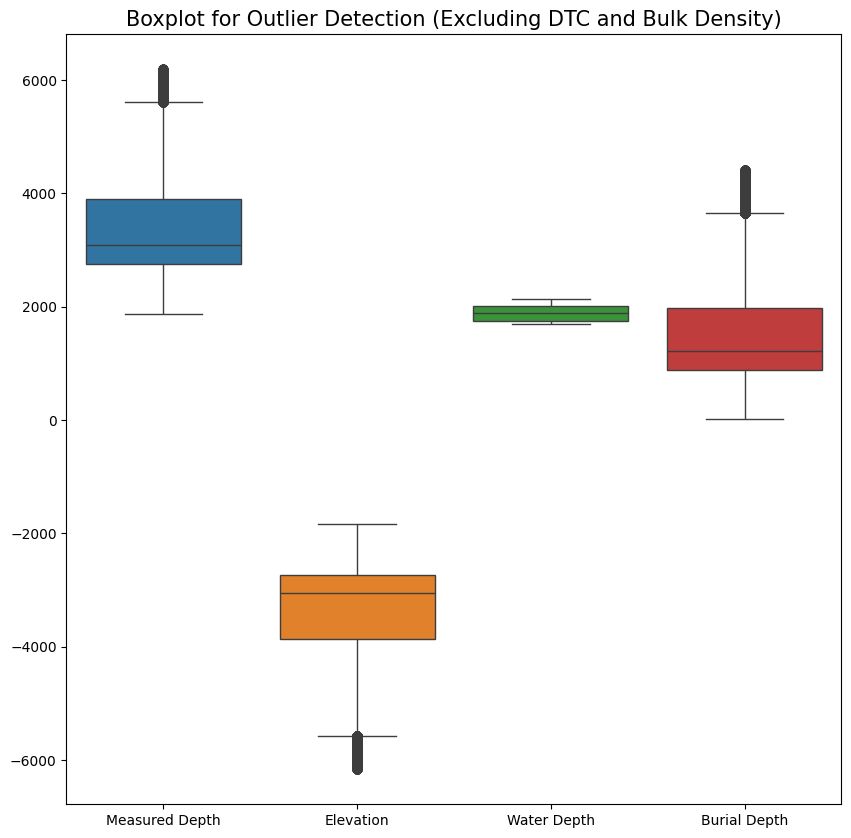

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Considera somente colunas de profundidade (Cota, TVD, Profundidade Medida, LDA, Soterramento)
dados_para_boxplot = numeric_dataset.drop(columns=["DTC", "Bulk Density"])

# Cria o boxplot
fig2 = plt.figure(figsize=(10, 10))
sns.boxplot(data=dados_para_boxplot)

# Adiciona título
plt.title('Boxplot for Outlier Detection (Excluding DTC and Bulk Density)', fontsize=15)

# Exibe o gráfico
plt.show()


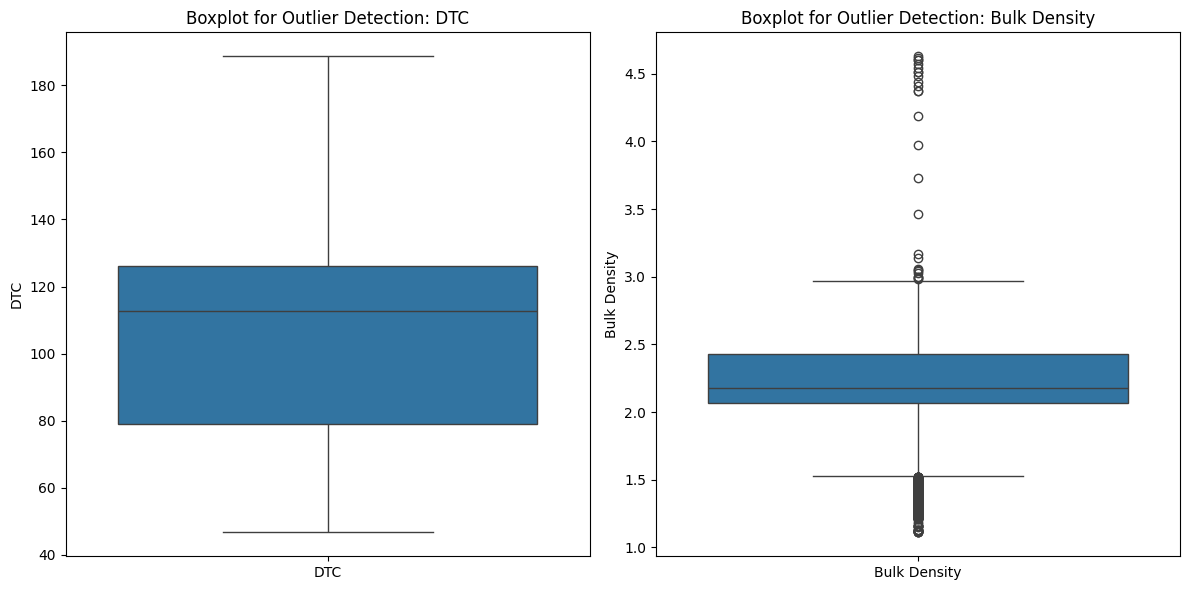

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Seleciona apenas as colunas desejadas
colunas = ["DTC", "Bulk Density"]

# Cria os subplots lado a lado
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Cria um boxplot para cada coluna
for i, col in enumerate(colunas):
    sns.boxplot(data=numeric_dataset[[col]], ax=axes[i], orient='v')
    axes[i].set_title(f'Boxplot for Outlier Detection: {col}')
    axes[i].set_ylabel(col)

# Ajusta layout e exibe
plt.tight_layout()
plt.show()

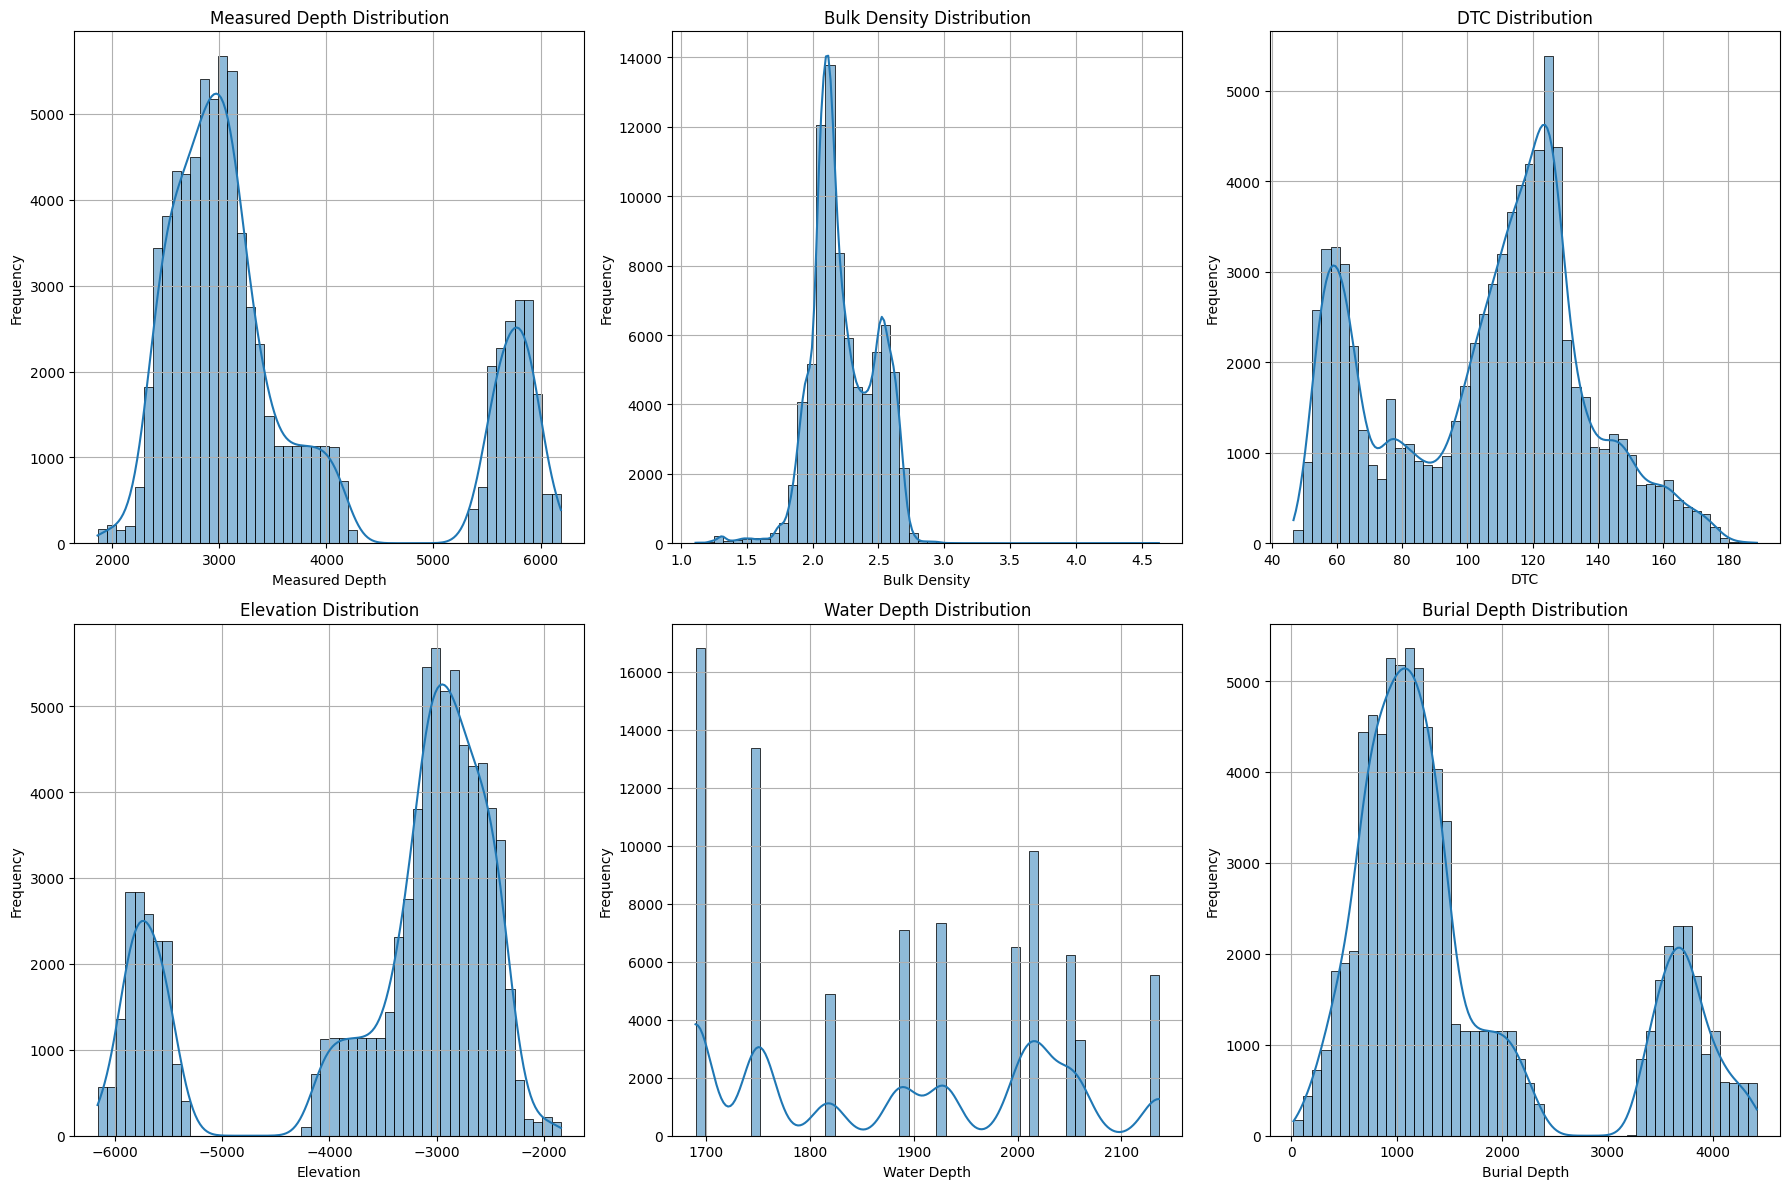

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Seleciona as colunas desejadas
colunas = ['Measured Depth', 'Bulk Density', 'DTC', 'Elevation', "Water Depth", 'Burial Depth']

# Cria subplots em grade 2x3 (6 espaços)
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
axes = axes.flatten()  # Transforma 2D em 1D para iteração

# Gera um histograma com KDE para cada coluna
for i, col in enumerate(colunas):
    sns.histplot(numeric_dataset[col].dropna(), kde=True, bins=50, ax=axes[i])
    axes[i].set_title(f'{col} Distribution')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')
    axes[i].grid(True)

# Ajusta layout
plt.tight_layout()
plt.show()




In [ ]:
densidade = numeric_dataset['Bulk Density']
Q1 = densidade.quantile(0.25)
Q3 = densidade.quantile(0.75)
IQR = Q3 - Q1

# Limites superiores
limite_superior_comum = Q3 + 1.5 * IQR
limite_superior_extremo = Q3 + 3.0 * IQR

# Limites inferiores
limite_inferior_comum = Q1 - 1.5 * IQR
limite_inferior_extremo = Q1 - 3.0 * IQR

print(f"IQR: {IQR:.3f}")
print(f"Limite inferior para outliers comuns: {limite_inferior_comum:.3f}")
print(f"Limite inferior para outliers severos: {limite_inferior_extremo:.3f}")
print(f"Limite superior para outliers comuns: {limite_superior_comum:.3f}")
print(f"Limite superior para outliers severos: {limite_superior_extremo:.3f}")
print(f"Valores típicos para rochas sedimentares: entre 1.0 e 3.2 g/cm³")

outliers_comuns = densidade[densidade > limite_superior_comum]
outliers_severos = densidade[densidade > 3.51]
outliers_3_2 = densidade[densidade > 3.2]
outliers_inferiores_comuns = densidade[densidade < limite_inferior_comum]
outliers_inferiores_severos = densidade[densidade < limite_inferior_extremo]

print(f"Quantidade de outliers comuns acima do limite (>{limite_superior_comum:.3f} g/cm³): {len(outliers_comuns)}")
print(f"Quantidade de outliers severos acima do limite (>{limite_superior_extremo:.3f} g/cm³): {len(outliers_severos)}")
print(f"Quantidade de outliers acima de 3.2 g/cm³ (limite típico para rochas sedimentares): {len(outliers_3_2)}")
print(f"Quantidade de outliers comuns abaixo do limite (<{limite_inferior_comum:.3f} g/cm³): {len(outliers_inferiores_comuns)}")
print(f"Quantidade de outliers severos abaixo do limite: (<{limite_inferior_extremo:.3f} g/cm³): {len(outliers_inferiores_severos)}")
print(f"Quantidade de outliers abaixo de 1.0 g/cm³ (limite típico para rochas sedimentares): {len(densidade[densidade < 1])}")


IQR: 0.360
Limite inferior para outliers comuns: 1.530
Limite inferior para outliers severos: 0.990
Limite superior para outliers comuns: 2.970
Limite superior para outliers severos: 3.510
Valores típicos para rochas sedimentares: entre 1.0 e 3.2 g/cm³
Quantidade de outliers comuns acima do limite (>2.970 g/cm³): 27
Quantidade de outliers severos acima do limite (>3.510 g/cm³): 16
Quantidade de outliers acima de 3.2 g/cm³ (limite típico para rochas sedimentares): 17
Quantidade de outliers comuns abaixo do limite (<1.530 g/cm³): 545
Quantidade de outliers severos abaixo do limite: (<0.990 g/cm³): 0
Quantidade de outliers abaixo de 1.0 g/cm³ (limite típico para rochas sedimentares): 0


# **Remoção dos Outliers de DTC e DENSIDADE**

In [ ]:
# Remove valores fora da faixa de DT COMPRESSIONAL (40 a 240 µs/pé)
dataset = dataset[(dataset['DTC'] >= 40) & (dataset['DTC'] <= 240)]
n_sem_dt_outliers = dataset.shape[0]
perc_dt_outliers = (n_sem_evaporitos - n_sem_dt_outliers) / n_total * 100

# Remove valores fora da faixa de DENSIDADE (1 a 3.2 g/cm³)
dataset = dataset[(dataset['Bulk Density'] >= 1.0) & (dataset['Bulk Density'] <= 3.2)]
n_final = dataset.shape[0]
perc_densidade_outliers = (n_sem_dt_outliers - n_final) / n_total * 100

In [ ]:
# Resultado final
print(f"Total de linhas originais: {n_total}")
print(f"Removidas por valores ausentes: {n_total - n_sem_nan} linhas ({perc_nan:.2f}%)")
print(f"Removidas por litologias evaporíticas: {n_sem_nan - n_sem_evaporitos} linhas ({perc_evaporitos:.2f}%)")
print(f"Removidas por DT COMPRESSIONAL fora da faixa: {n_sem_evaporitos - n_sem_dt_outliers} linhas ({perc_dt_outliers:.2f}%)")
print(f"Removidas por DENSIDADE fora da faixa: {n_sem_dt_outliers - n_final} linhas ({perc_densidade_outliers:.2f}%)")
print(f"Total final de linhas: {n_final} ({(n_final / n_total) * 100:.2f}% do original)")

Total de linhas originais: 152231
Removidas por valores ausentes: 41790 linhas (27.45%)
Removidas por litologias evaporíticas: 29582 linhas (19.43%)
Removidas por DT COMPRESSIONAL fora da faixa: 0 linhas (0.00%)
Removidas por DENSIDADE fora da faixa: 17 linhas (0.01%)
Total final de linhas: 80842 (53.10% do original)


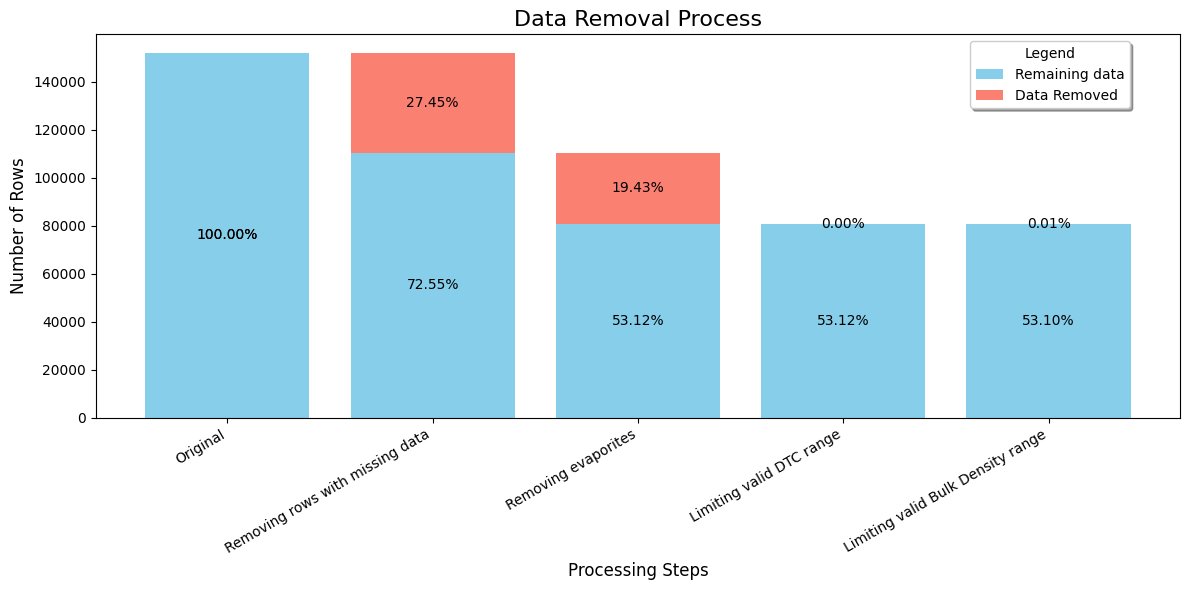

In [ ]:
# Dados para o gráfico
etapas = ['Original', 'Removing rows with missing data', 'Removing evaporites',
          'Limiting valid DTC range', 'Limiting valid Bulk Density range']

removidos = [
    0,  # Nenhuma linha removida no início
    n_total - n_sem_nan,  # Removidos por valores ausentes
    n_sem_nan - n_sem_evaporitos,  # Removidos por litologias evaporíticas
    n_sem_evaporitos - n_sem_dt_outliers,  # Removidos por DT COMPRESSIONAL fora da faixa
    n_sem_dt_outliers - n_final,  # Removidos por DENSIDADE fora da faixa
]

# Cálculo das linhas restantes por cada etapa
linhas_restantes = [n_total]  # A primeira etapa começa com todos os dados
for i in range(1, len(removidos)):
    linhas_restantes.append(linhas_restantes[-1] - removidos[i])  # Subtrai os dados removidos

# Visualização com gráfico de barras empilhadas
fig, ax = plt.subplots(figsize=(12, 6))  # Tamanho maior para evitar sobreposição

# Barras empilhadas para as linhas restantes (em azul)
ax.bar(etapas, linhas_restantes, label="Remaining data", color='skyblue')

# Barras para as linhas removidas (em vermelho)
# Corrigir para que as barras removidas empilhem corretamente
ax.bar(etapas[1:], removidos[1:], label="Data Removed", bottom=linhas_restantes[1:], color='salmon')

# Adicionando título e rótulos
ax.set_title('Data Removal Process', fontsize=16)
ax.set_xlabel('Processing Steps', fontsize=12)
ax.set_ylabel('Number of Rows', fontsize=12)

# Adicionando percentuais nas barras
for i, (restante, removido) in enumerate(zip(linhas_restantes, removidos)):
    total = n_total

    # Para a primeira coluna (Original), não mostrar percentual de dados removidos
    if i == 0:
        ax.text(i, restante / 2, f'{(restante / total) * 100:.2f}%', ha='center', va='center', fontsize=10, color='black')
    else:
        ax.text(i, restante + removido / 2, f'{(removido / total) * 100:.2f}%', ha='center', va='center', fontsize=10, color='black')

    # Adicionando o percentual restante para todas as etapas
    ax.text(i, restante / 2, f'{(restante / total) * 100:.2f}%', ha='center', va='center', fontsize=10, color='black')

# Ajustando a legenda para o lado direito do gráfico
ax.legend(title="Legend", loc="upper left", bbox_to_anchor=(0.8, 1), shadow=True)

# Melhorando a posição dos rótulos do eixo X
ax.set_xticks(range(len(etapas)))  # Coloca as posições dos rótulos
ax.set_xticklabels(etapas, rotation=30, ha="right")  # Aplica rotação e ajuste de alinhamento

# Exibindo o gráfico
plt.tight_layout()  # Ajusta o layout para evitar sobreposição
plt.show()




# Gráfico com Distribuição de litologia


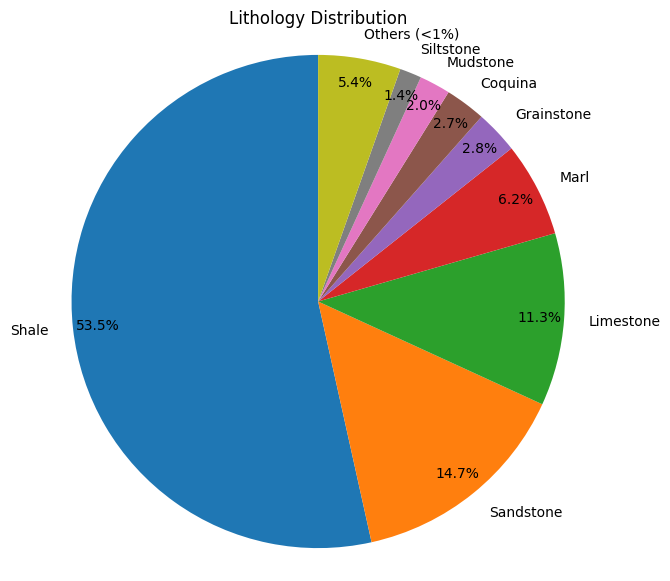

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Conta os valores absolutos
valores_abs = dataset['Interpreted Lithology (system)'].value_counts()
total = valores_abs.sum()

# Calcula porcentagem
valores_pct = valores_abs / total * 100

# Separa os dados
principais = valores_abs[valores_pct >= 1]
outros = valores_abs[valores_pct < 1].sum()

# Cria novo DataFrame com "Outros"
valores_com_outros = principais.copy()
if outros > 0:
    valores_com_outros['Others (<1%)'] = outros

# Gera novo vetor de porcentagens
porcentagens = valores_com_outros / valores_com_outros.sum() * 100

# Função para mostrar apenas rótulos significativos
def mostrar_pct(pct):
    return f'{pct:.1f}%' if pct > 1 else ''

# Gráfico de pizza com "Outros"
plt.figure(figsize=(7, 7))
plt.pie(valores_com_outros, labels=valores_com_outros.index, autopct=mostrar_pct, startangle=90, pctdistance=0.9)
plt.title("Lithology Distribution")
plt.axis('equal')
plt.show()


In [ ]:
# Converte para DataFrame
tabela = valores_pct.reset_index()
tabela.columns = ['Classe', 'Porcentagem (%)']

# Exibe a tabela formatada
print(tabela)

                      Classe  Porcentagem (%)
0                      Shale        53.477153
1                  Sandstone        14.681725
2                  Limestone        11.309715
3                       Marl         6.192326
4                 Grainstone         2.817842
5                    Coquina         2.652087
6                   Mudstone         2.032359
7                  Siltstone         1.427476
8                  Argillite         0.790431
9                Silty Shale         0.781772
10                 Packstone         0.702605
11                  Rudstone         0.680339
12              Spherulitite         0.431706
13     Unidentified Volcanic         0.353777
14  Arborescent Stromatolite         0.270899
15                  Dolomite         0.241211
16      Shrubby Stromatolite         0.225131
17              Stromatolite         0.186784
18                  Laminite         0.162044
19                Floatstone         0.158334
20       Crenulated Laminite      

# Gráfico com Distribuição de Dados por Poço

In [ ]:
# Conta os valores de poço
valores_poco_abs = dataset['Well'].value_counts()
valores_poco_pct = valores_poco_abs / valores_poco_abs.sum() * 100

labels = valores_poco_pct.index

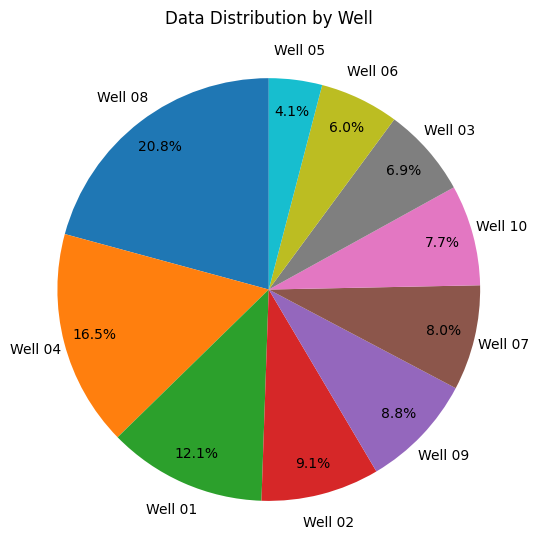

In [ ]:
# Cria o gráfico de pizza
plt.figure(figsize=(6, 6))
plt.pie(
    valores_poco_pct,
    labels=labels,
    autopct='%.1f%%',
    startangle=90,
    pctdistance=0.85,
    labeldistance=1.14,
    textprops={'ha': 'center', 'fontsize': 10}  # Centraliza os labels horizontalmente
)
plt.title('Data Distribution by Well', pad=25)
plt.axis('equal')  # Mantém formato circular
plt.show()

# Matrizes de correlação

## Montando Matriz de Correlação entre as variáveis para todo o DataSet

In [ ]:
# Calcula a correlação apenas nas colunas numéricas
corr_Pearson = numeric_dataset.corr() # correlação Pearson

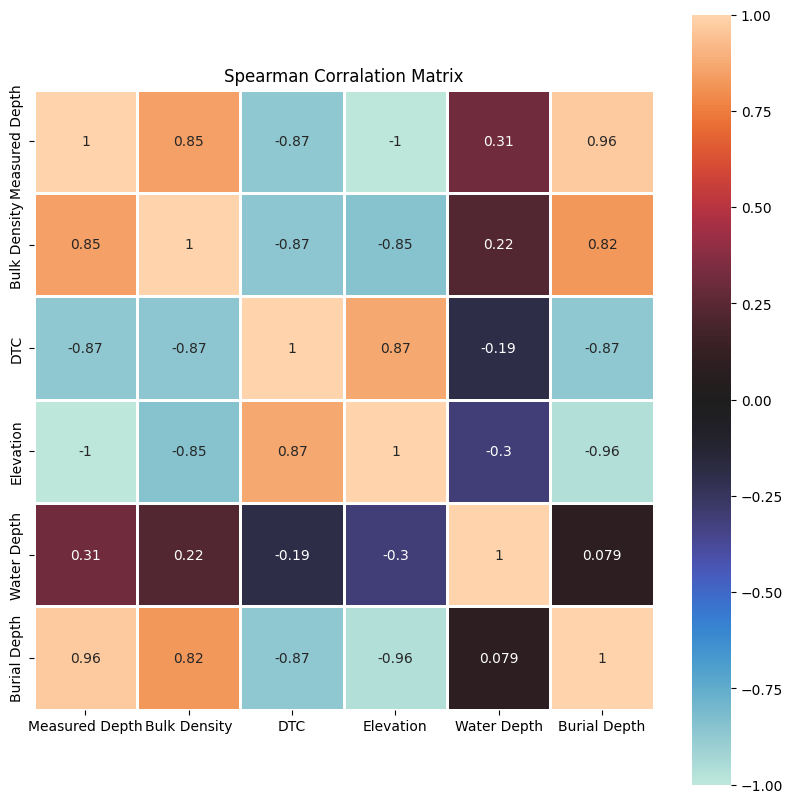

In [ ]:
import seaborn as sns

corr_Spearman = numeric_dataset.iloc[:,:].corr(method='spearman')

fig = plt.figure(figsize=(10,10))
ax = sns.heatmap(corr_Spearman,
                 vmin=-1,
                 vmax=1,
                 center=0,
                 square=True,
                 annot=True,
                 linewidths=0.8)
ax.set_ylim(len(corr_Spearman),0)
plt.title('Spearman Corralation Matrix')
plt.show()

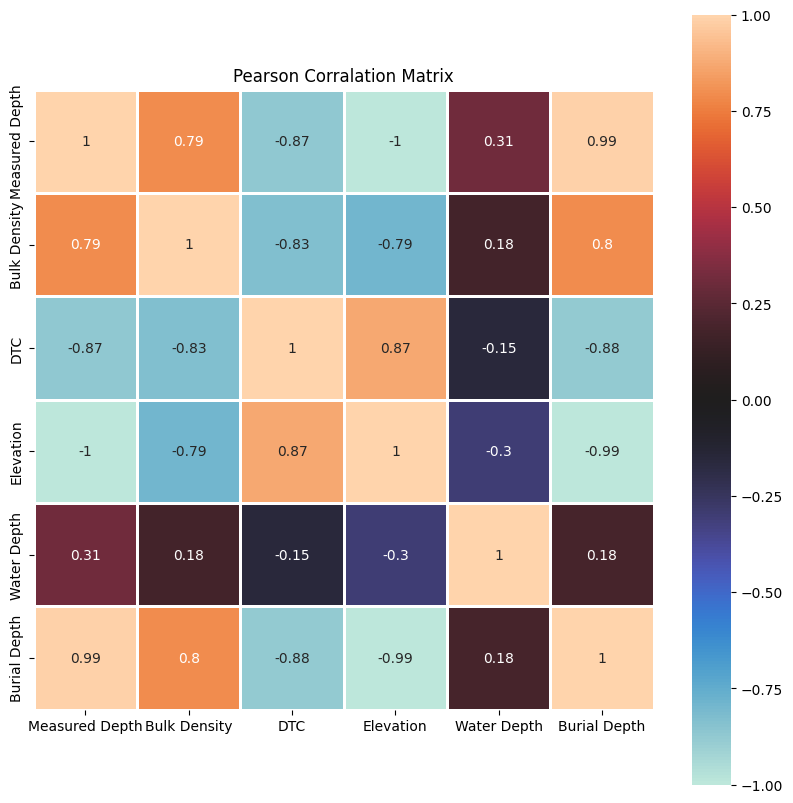

In [ ]:
import seaborn as sns

import matplotlib.pyplot as plt

fig1 = plt.figure(figsize=(10,10))
ax = sns.heatmap(corr_Pearson,
                 vmin=-1,
                 vmax=1,
                 center=0,
                 square=True,
                 annot=True,
                 linewidths=0.8)
ax.set_ylim(len(corr_Pearson),0)
plt.title('Pearson Corralation Matrix')
plt.show()

# Seleção de Variáveis

## PCA

In [ ]:
!pip install prince
import prince

# Configura PCA
pca = prince.PCA(
    n_components=7,
    n_iter=10,
    rescale_with_mean=True,
    rescale_with_std=True,
    engine='sklearn',
    random_state=200)

# Ajusta o modelo
pca = pca.fit(numeric_dataset)

# Mostra os autovalores
print(pca.eigenvalues_summary)


          eigenvalue % of variance % of variance (cumulative)
component                                                    
0              4.611        76.84%                     76.84%
1              0.953        15.88%                     92.73%
2              0.302         5.04%                     97.76%
3              0.134         2.24%                    100.00%
4              0.000         0.00%                    100.00%
5              0.000         0.00%                    100.00%


O que isso mostra:

O componente 0 captura mais que 75% da variância total dos dados.

Os três primeiros componentes somam quase 98% da variância, o que significa que a maioria da informação dos dados pode ser representada em 2 ou 3 dimensões.

In [ ]:
pca.scree_plot()

alt.Chart(...)

In [ ]:
pca.column_contributions_.style.format('{:.0%}')

A componente 2 representa fortemente a DENSIDADE. Isso é essencial, porque mostra que a variabilidade da densidade está em uma direção separada das demais (componentes 0 e 1), sugerindo que ela tem comportamento próprio, e pode ser prevista por um subconjunto específico de variáveis.

In [ ]:
pca.column_correlations

component              0         1         2         3         4             5
variable                                                                      
Measured Depth  0.983655  0.028004 -0.169154  0.054842  0.004146  1.037450e-28
Bulk Density    0.876991 -0.111590  0.441524  0.153266  0.000004 -2.879697e-31
DTC            -0.929647  0.150548 -0.114191  0.316309  0.000004  1.841268e-31
Elevation      -0.983697 -0.023757  0.169368 -0.055548  0.002023 -4.180153e-15
Water Depth     0.298512  0.952094  0.059890 -0.028658 -0.000286 -5.283800e-16
Burial Depth    0.976212 -0.099678 -0.182596  0.061062 -0.002051 -4.050634e-15

In [ ]:
CP = pca.transform (numeric_dataset)
CP

component         0         1         2         3         4             5
0         -0.304922 -0.084514  1.852068  0.744887  0.003073 -5.464930e-15
1         -0.773072  0.044941  0.899427  0.201076  0.002047 -5.443428e-15
2         -1.630026  0.284549 -0.791899 -0.688470  0.000312 -5.366415e-15
3         -1.746274  0.318288 -0.998477 -0.761959  0.000139 -5.313075e-15
4         -1.673971  0.300319 -0.813409 -0.599974  0.000401 -5.291572e-15
...             ...       ...       ...       ...       ...           ...
152174     4.018384  1.211362 -0.634025 -0.127218  0.019320 -6.784859e-15
152175     4.033601  1.207286 -0.601833 -0.106193  0.019357 -6.772142e-15
152176     4.031370  1.208136 -0.603109 -0.101333  0.019362 -6.741854e-15
152177     4.047165  1.203858 -0.570653 -0.081435  0.019398 -6.577492e-15
152178     4.046492  1.204154 -0.571182 -0.079680  0.019400 -6.786820e-15

[80859 rows x 6 columns]

## PCA sem coluna Densidade

In [ ]:
# 1. Retira a variável alvo para PCA técnico
X = numeric_dataset.drop(columns=['Bulk Density'])

# 2. Aplica PCA
pca = prince.PCA(
    n_components=6,
    n_iter=10,
    rescale_with_mean=True,
    rescale_with_std=True,
    engine='sklearn',
    random_state=200)
pca = pca.fit(X)

# Mostra os autovalores
print(pca.eigenvalues_summary)

          eigenvalue % of variance % of variance (cumulative)
component                                                    
0              3.888        77.77%                     77.77%
1              0.942        18.84%                     96.60%
2              0.170         3.39%                    100.00%
3              0.000         0.00%                    100.00%
4              0.000         0.00%                    100.00%


In [ ]:
pca.scree_plot()

alt.Chart(...)

In [ ]:
pca.column_contributions_.style.format('{:.0%}')

In [ ]:
pca.column_correlations

component              0         1         2         3             4
variable                                                            
Measured Depth  0.993702 -0.005875 -0.111825  0.004162 -5.736727e-29
DTC            -0.918318  0.170262 -0.357355  0.000002  3.777297e-32
Elevation      -0.993609  0.010113  0.112401  0.002031  7.754672e-16
Water Depth     0.321226  0.945924  0.045181 -0.000287  9.802065e-17
Burial Depth    0.983478 -0.133826 -0.121889 -0.002058  7.514398e-16

In [ ]:
CP = pca.transform (numeric_dataset)
CP

component         0         1         2         3             4
0         -1.087086  0.179943  0.184866  0.001375  1.052220e-15
1         -1.064053  0.171318  0.227300  0.001356  1.143982e-15
2         -1.059748  0.169749  0.234850  0.001353  1.124721e-15
3         -1.075835  0.175865  0.204389  0.001366  1.073771e-15
4         -1.107010  0.187662  0.145857  0.001391  1.054510e-15
...             ...       ...       ...       ...           ...
152174     3.995793  1.075159 -0.162724  0.019760 -2.927186e-16
152175     3.994007  1.075885 -0.166519  0.019761 -3.031943e-16
152176     3.991611  1.076840 -0.171448  0.019763 -3.312409e-16
152177     3.990447  1.077335 -0.174115  0.019764 -4.932126e-16
152178     3.989726  1.077659 -0.175925  0.019764 -2.816436e-16

[80859 rows x 5 columns]

## LASSO considerando coluna litologia

In [ ]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

df_lasso = dataset.copy()

df_lasso = df_lasso.drop(columns=['Well']) #Removendo coluna não útil

# Converter categorias em variáveis dummies
df_lasso = pd.get_dummies(df_lasso, columns=['Interpreted Lithology (system)'], drop_first=True)

# Seleciona X (variáveis) e y (alvo)
X = df_lasso.drop(columns=['Bulk Density'])
y = df_lasso['Bulk Density']

# Criar pipeline com normalização + Lasso com validação cruzada
lasso = make_pipeline(StandardScaler(), LassoCV(cv=5, random_state=42))

# Treinar o modelo
lasso.fit(X, y)

# Acessar o modelo treinado
modelo_lasso = lasso.named_steps['lassocv']

# Coeficientes das variáveis
coef = pd.Series(modelo_lasso.coef_, index=X.columns)
print("Coeficientes Lasso:")
print(coef)



Coeficientes Lasso:
Measured Depth                                          0.075841
DTC                                                    -0.121511
Elevation                                              -0.022112
Water Depth                                            -0.001791
Burial Depth                                            0.023789
Interpreted Lithology (system)_Argillite               -0.025464
Interpreted Lithology (system)_Basalt                   0.000668
Interpreted Lithology (system)_Carbonate Breccia        0.000461
Interpreted Lithology (system)_Chert                   -0.000563
Interpreted Lithology (system)_Coquina                 -0.007133
Interpreted Lithology (system)_Crenulated Laminite     -0.000527
Interpreted Lithology (system)_Crystalline Limestone    0.000107
Interpreted Lithology (system)_Dolomite                 0.000576
Interpreted Lithology (system)_Floatstone              -0.002927
Interpreted Lithology (system)_Grainstone              -0.005656
Inter

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.492e+00, tolerance: 4.655e-01
  model = cd_fast.enet_coordinate_descent(


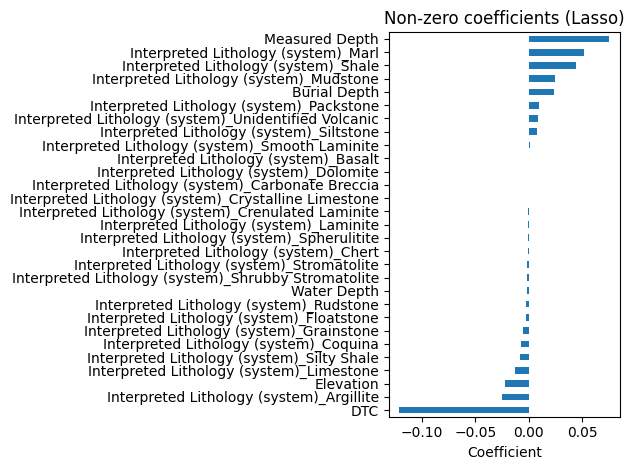

In [ ]:
coef[coef != 0].sort_values().plot(kind="barh", title="Non-zero coefficients (Lasso)")
plt.xlabel("Coefficient")
plt.tight_layout()
plt.show()

In [ ]:
# Organizar coeficientes em ordem decrescente de valor absoluto
coef_abs_sorted = coef.abs().sort_values(ascending=False)

# Criar DataFrame para visualizar
coef_df = pd.DataFrame({
    'Coefficient': coef[coef_abs_sorted.index],  # Coeficientes ordenados
    'Magnitude': coef_abs_sorted,  # Magnitude (valor absoluto)
    'Zeroed': coef[coef_abs_sorted.index] == 0  # Indica se o coeficiente foi zerado
})

# Exibir a tabela ordenada
print(coef_df)

                                                    Coefficient  Magnitude  \
DTC                                                   -0.121511   0.121511   
Measured Depth                                         0.075841   0.075841   
Interpreted Lithology (system)_Marl                    0.052070   0.052070   
Interpreted Lithology (system)_Shale                   0.044063   0.044063   
Interpreted Lithology (system)_Argillite              -0.025464   0.025464   
Interpreted Lithology (system)_Mudstone                0.024916   0.024916   
Burial Depth                                           0.023789   0.023789   
Elevation                                             -0.022112   0.022112   
Interpreted Lithology (system)_Limestone              -0.012503   0.012503   
Interpreted Lithology (system)_Packstone               0.009896   0.009896   
Interpreted Lithology (system)_Unidentified Vol...     0.008685   0.008685   
Interpreted Lithology (system)_Silty Shale            -0.008559 

## Lasso considerando somente variáveis numéricas

Coeficientes Lasso (≠ 0):
DTC         -0.137157
Elevation   -0.059787
dtype: float64


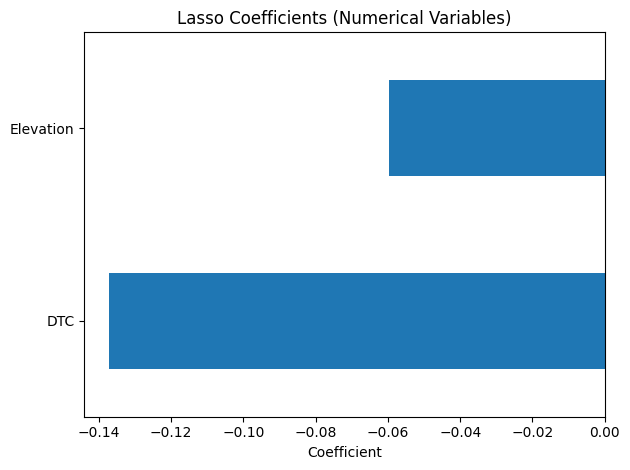

In [ ]:
import pandas as pd
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Copia da base original (suponha que 'dataset' é o DataFrame carregado)
df_lasso = numeric_dataset.copy()

# Separa variável alvo (DENSIDADE) e preditoras
X = df_lasso.drop(columns=['Bulk Density'])
y = df_lasso['Bulk Density']

# Cria pipeline: padronização + Lasso com validação cruzada
pipeline = make_pipeline(StandardScaler(), LassoCV(cv=5, random_state=42))

# Treina o modelo
pipeline.fit(X, y)

# Extrai modelo treinado de dentro do pipeline
modelo_lasso = pipeline.named_steps['lassocv']

# Extrai os coeficientes
coef = pd.Series(modelo_lasso.coef_, index=X.columns)

# Exibe os coeficientes diferentes de zero
print("Coeficientes Lasso (≠ 0):")
print(coef[coef != 0])

# Visualiza os coeficientes
coef[coef != 0].sort_values().plot(kind='barh', title='Lasso Coefficients (Numerical Variables)')
plt.xlabel("Coefficient")
plt.tight_layout()
plt.show()


In [ ]:
# Organizar coeficientes em ordem decrescente de valor absoluto
coef_abs_sorted = coef.abs().sort_values(ascending=False)

# Criar DataFrame para visualizar
coef_df = pd.DataFrame({
    'Coeficiente': coef[coef_abs_sorted.index],  # Coeficientes ordenados
    'Magnitude': coef_abs_sorted,  # Magnitude (valor absoluto)
    'Zerado': coef[coef_abs_sorted.index] == 0  # Indica se o coeficiente foi zerado
})

# Exibir a tabela ordenada
print(coef_df)

                Coeficiente  Magnitude  Zerado
DTC               -0.137157   0.137157   False
Elevation         -0.059787   0.059787   False
Measured Depth     0.000000   0.000000    True
Water Depth        0.000000   0.000000    True
Burial Depth       0.000000   0.000000    True


# **Análise com Gardner**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [ ]:
# Equação de Gardner: ρ = a * Vp^b
def gardner(Vp, a, b):
    return a * (Vp ** b)

In [ ]:
# Inicializa dicionário para guardar parâmetros por poço
parametros_por_poco = {}

# Lista única de poços
pocos = dataset["Well"].unique()

pocos

array(['Well 09', 'Well 08', 'Well 07', 'Well 10', 'Well 06', 'Well 04',
       'Well 05', 'Well 01', 'Well 02', 'Well 03'], dtype=object)

📦 curve_fit – o que é?

A função curve_fit do módulo scipy.optimize realiza ajuste de curvas não-lineares a partir de uma função arbitrária definida pelo usuário. No nosso caso, a função é gardner(Vp, a, b).

🧱 Estrutura geral de uso:

popt, pcov = curve_fit(funcao_modelo, x_dados, y_dados)

funcao_modelo: sua função matemática que descreve o modelo (ex: gardner)

x_dados: variáveis independentes (aqui, Vp)

y_dados: variáveis dependentes (aqui, rho)

popt: vetor com os melhores parâmetros estimados

pcov: matriz de covariância dos parâmetros, usada para incerteza (omitida com _ neste código)



In [ ]:
# Ajuste com dados de treinamento
df_gardnertrain = dataset[~dataset["Well"].isin(["Well 04", "Well 01"])]
Vp_gardnertrain = 304800 / df_gardnertrain["DTC"].values
rho_gardnertrain = df_gardnertrain["Bulk Density"].values
popt_train, _ = curve_fit(gardner, Vp_gardnertrain, rho_gardnertrain, maxfev=10000)
a_gardnertrain, b_gardnertrain = popt_train

In [ ]:
# from scipy.optimize import curve_fit
from sklearn.metrics import r2_score, mean_squared_error
# import numpy as np

# Dicionários para armazenar os resultados
parametros_por_poco = {}
r2_por_poco_ajustado = {}
r2_por_poco_treinamento = {}


for poco in pocos:
    dados_poco = dataset[dataset["Well"] == poco]
    Vp = 304800 / dados_poco["DTC"]
    rho = dados_poco["Bulk Density"].values

    try:
        # Ajuste do modelo de Gardner por poço
        popt, _ = curve_fit(gardner, Vp, rho, maxfev=10000)
        a_fit, b_fit = popt
        parametros_por_poco[poco] = {"a": a_fit, "b": b_fit}

        # Previsões
        rho_pred_fit = gardner(Vp, a_fit, b_fit)
        rho_pred_train = gardner(Vp, a_gardnertrain, b_gardnertrain)

        # Cálculo do R²
        r2_fit = r2_score(rho, rho_pred_fit)
        r2_train = r2_score(rho, rho_pred_train)

        r2_por_poco_ajustado[poco] = r2_fit
        r2_por_poco_treinamento[poco] = r2_train

    except RuntimeError:
        print(f"Não foi possível ajustar Gardner para o poço {poco}")
        parametros_por_poco[poco] = {"a": np.nan, "b": np.nan}
        r2_por_poco_ajustado[poco] = np.nan
        r2_por_poco_treinamento[poco] = np.nan

In [ ]:
# Mostra parâmetros calculados
print(f"Parâmetros de Gardner com dados de treinamento: a = {a_gardnertrain:.5f}, b = {b_gardnertrain:.5f}")

# Lista para armazenar os dados
tabela_parametros = []

for poco in sorted(pocos):
    a = parametros_por_poco[poco]["a"]
    b = parametros_por_poco[poco]["b"]
    r2_fit = r2_por_poco_ajustado[poco]
    r2_train = r2_por_poco_treinamento[poco]

    tabela_parametros.append({
        "Poço": poco,
        "a (ajustado)": round(a, 6),
        "b (ajustado)": round(b, 6),
        "R² Ajustado (poço)": round(r2_fit, 4),
        "R² Treinamento": round(r2_train, 4)
    })

# Cria o DataFrame
df_parametros = pd.DataFrame(tabela_parametros)

# # Exibe a tabela ordenada por Poço
# print("\nParâmetros por poço:")
# print(df_parametros.to_string(index=False))


Parâmetros de Gardner com dados de treinamento: a = 0.26553, b = 0.26436


# **Início dos Modelos**

## **Criação de colunas Dummies**

In [ ]:
!pip install fast_ml

In [ ]:
## Colunas Dummies para todas as litologias

# Copiar o DataFrame original
df = dataset.copy()

# Criar dummies diretamente da coluna original
df_dummies = pd.get_dummies(df["Interpreted Lithology (system)"], prefix='lito')

# Concatenar os dummies ao DataFrame original e remover a coluna original
df = pd.concat([df, df_dummies], axis=1)

df

Well Measured Depth Bulk Density     DTC Elevation  \
0       Well 09         2856.0         2.64  117.43  -2828.81   
1       Well 09        2856.15         2.35  115.93  -2828.96   
2       Well 09         2856.3         1.84  115.66  -2829.11   
3       Well 09        2856.46         1.78  116.73  -2829.27   
4       Well 09        2856.61         1.84  118.79  -2829.42   
...         ...            ...          ...     ...       ...   
152174  Well 03        6017.21         2.46   59.06  -5945.61   
152175  Well 03        6017.36         2.47   59.19  -5945.76   
152176  Well 03        6017.51         2.47   59.36  -5945.91   
152177  Well 03        6017.67         2.48   59.45  -5946.07   
152178  Well 03        6017.82         2.48   59.51  -5946.22   

       Interpreted Lithology (system) Water Depth Burial Depth  \
0                               Shale      1888.0       940.81   
1                               Shale      1888.0       940.96   
2                               Shale      1888.0       941.11   
3                               Shale      1888.0       941.27   
4                               Shale      1888.0       941.42   
...                               ...         ...          ...   
152174                        Coquina      2136.0      3809.61   
152175                        Coquina      2136.0      3809.76   
152176                        Coquina      2136.0      3809.91   
152177                        Coquina      2136.0      3810.07   
152178                        Coquina      2136.0      3810.22   

        lito_Arborescent Stromatolite  lito_Argillite  ...  lito_Sandstone  \
0                               False           False  ...           False   
1                               False           False  ...           False   
2                               False           False  ...           False   
3                               False           False  ...           False   
4                               False           False  ...           False   
...                               ...             ...  ...             ...   
152174                          False           False  ...           False   
152175                          False           False  ...           False   
152176                          False           False  ...           False   
152177                          False           False  ...           False   
152178                          False           False  ...           False   

        lito_Shale  lito_Shrubby Stromatolite  lito_Siltstone  \
0             True                      False           False   
1             True                      False           False   
2             True                      False           False   
3             True                      False           False   
4             True                      False           False   
...            ...                        ...             ...   
152174       False                      False           False   
152175       False                      False           False   
152176       False                      False           False   
152177       False                      False           False   
152178       False                      False           False   

        lito_Silty Shale  lito_Smooth Laminite  lito_Spherulitite  \
0                  False                 False              False   
1                  False                 False              False   
2                  False                 False              False   
3                  False                 False              False   
4                  False                 False              False   
...                  ...                   ...                ...   
152174             False                 False              False   
152175             False                 False              False   
152176             False                 False              False   
152177             False     

## **Divisão de dados em conjuntos de treinamento, Teste 1 e Teste 2**

In [ ]:
# Subconjuntos por poço
df_test1 = df[df["Well"] == "Well 04"]
df_test2  = df[df["Well"] == "Well 01"]
df_train = df[~df["Well"].isin(["Well 04", "Well 01"])]


In [ ]:
# Seleciona só as colunas de entrada na hora de criar X
X_train = df_train.drop(columns=["Bulk Density", "Well", "Elevation", "Water Depth", "Interpreted Lithology (system)", 'Measured Depth'])
y_train = df_train["Bulk Density"]

X_test1 = df_test1.drop(columns=["Bulk Density", "Well", "Elevation", "Water Depth", "Interpreted Lithology (system)", 'Measured Depth'])
y_test1 = df_test1["Bulk Density"]

X_test2  = df_test2.drop(columns=["Bulk Density", "Well", "Elevation", "Water Depth", "Interpreted Lithology (system)", 'Measured Depth'])
y_test2  = df_test2["Bulk Density"]


In [ ]:
print("Variáveis selecionadas para X:")

print("X_train:", X_train.columns.tolist())
print(f"Número de variáveis em X_train: {len(X_train.columns)}")

print("X_test1:", X_test1.columns.tolist())
print(f"Número de variáveis em X_test1: {len(X_test1.columns)}")

print("X_test2:", X_test2.columns.tolist())
print(f"Número de variáveis em X_test2: {len(X_test2.columns)}")


Variáveis selecionadas para X:
X_train: ['DTC', 'Burial Depth', 'lito_Arborescent Stromatolite', 'lito_Argillite', 'lito_Basalt', 'lito_Carbonate Breccia', 'lito_Chert', 'lito_Coquina', 'lito_Crenulated Laminite', 'lito_Crystalline Limestone', 'lito_Dolomite', 'lito_Floatstone', 'lito_Grainstone', 'lito_Laminite', 'lito_Limestone', 'lito_Marl', 'lito_Mudstone', 'lito_Packstone', 'lito_Rudstone', 'lito_Sandstone', 'lito_Shale', 'lito_Shrubby Stromatolite', 'lito_Siltstone', 'lito_Silty Shale', 'lito_Smooth Laminite', 'lito_Spherulitite', 'lito_Stromatolite', 'lito_Unidentified Volcanic', 'lito_Wackestone']
Número de variáveis em X_train: 29
X_test1: ['DTC', 'Burial Depth', 'lito_Arborescent Stromatolite', 'lito_Argillite', 'lito_Basalt', 'lito_Carbonate Breccia', 'lito_Chert', 'lito_Coquina', 'lito_Crenulated Laminite', 'lito_Crystalline Limestone', 'lito_Dolomite', 'lito_Floatstone', 'lito_Grainstone', 'lito_Laminite', 'lito_Limestone', 'lito_Marl', 'lito_Mudstone', 'lito_Packstone', '

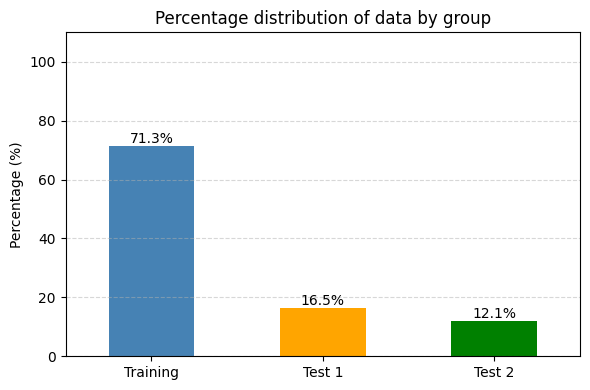

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Conta o número de registros em cada conjunto
n_train = len(X_train)
n_test1 = len(X_test1)
n_test2 = len(X_test2)
n_total = n_train + n_test1 + n_test2

# Calcula as porcentagens
porcentagens = {
    "Training": n_train / n_total * 100,
    "Test 1": n_test1 / n_total * 100,
    "Test 2": n_test2 / n_total * 100
}

# Converte para DataFrame
df_pct = pd.DataFrame.from_dict(porcentagens, orient='index', columns=["Percentage"])

# Cria gráfico de barras
plt.figure(figsize=(6, 4))
bars = df_pct["Percentage"].plot(kind="bar", color=["steelblue", "orange", "green"])

# Adiciona os valores sobre cada barra
for i, v in enumerate(df_pct["Percentage"]):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center', fontsize=10)

plt.ylabel("Percentage (%)")
plt.title("Percentage distribution of data by group")
plt.ylim(0, 110)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()



Normalização dos Dados de Treinamento

In [ ]:
# Normalização dos Dados de treinamento

from sklearn.preprocessing import MinMaxScaler

# Dados entrada treinamento

scaler1 = MinMaxScaler(feature_range = (0,1))
scaled_data1 = scaler1.fit_transform(X_train) #Normalizar cada variável segundo seu mínimo e máximo. O resultado scaled_data1 é um novo array onde cada coluna está no intervalo [0, 1]
train_entn = scaled_data1
#print(train_entn) #Valores de entrada normalizados

In [ ]:
# Dados saída treinamento
import numpy as np
y_train_array = pd.DataFrame(np.array(y_train)) #Transforma y_train em um DataFrame do pandas, garantindo que fique no formato 2D esperado pelo MinMaxScaler
scaler2 = MinMaxScaler(feature_range = (0,1))
scaled_data2 = scaler2.fit_transform(y_train_array)
train_sain = np.ravel(scaled_data2) #Trocar a dimensão do vetor condição necessária para rodar o modelo.
#print(train_sain) #Valores de saída normalizados

In [ ]:
# Dados entrada teste 1
test1_entn = scaler1.transform(X_test1) #Normalizar cada variável segundo seu mínimo e máximo.

# Dados entrada teste
test2_entn = scaler1.transform(X_test2) #Normalizar cada variável segundo seu mínimo e máximo.

In [ ]:
df_test1

Well Measured Depth Bulk Density     DTC Elevation  \
73327  Well 04        2576.78         1.35  143.56  -2551.78   
73328  Well 04        2576.93         1.35  139.37  -2551.93   
73329  Well 04        2577.08         1.39  135.34  -2552.08   
73330  Well 04        2577.24         1.44   128.2  -2552.24   
73331  Well 04        2577.39         1.47  126.92  -2552.39   
...        ...            ...          ...     ...       ...   
97027  Well 04        6188.66         2.67   57.79   -6163.6   
97028  Well 04        6188.81         2.65   58.02  -6163.75   
97029  Well 04        6188.96         2.63   58.22   -6163.9   
97030  Well 04        6189.12          2.6   58.34  -6164.06   
97031  Well 04        6189.27         2.61   58.39  -6164.21   

      Interpreted Lithology (system) Water Depth Burial Depth  \
73327                          Shale      1751.0       800.78   
73328                          Shale      1751.0       800.93   
73329                          Shale      1751.0       801.08   
73330                          Shale      1751.0       801.24   
73331                          Shale      1751.0       801.39   
...                              ...         ...          ...   
97027                          Shale      1751.0       4412.6   
97028                        Coquina      1751.0      4412.75   
97029                        Coquina      1751.0       4412.9   
97030                        Coquina      1751.0      4413.06   
97031                        Coquina      1751.0      4413.21   

       lito_Arborescent Stromatolite  lito_Argillite  ...  lito_Sandstone  \
73327                          False           False  ...           False   
73328                          False           False  ...           False   
73329                          False           False  ...           False   
73330                          False           False  ...           False   
73331                          False           False  ...           False   
...                              ...             ...  ...             ...   
97027                          False           False  ...           False   
97028                          False           False  ...           False   
97029                          False           False  ...           False   
97030                          False           False  ...           False   
97031                          False           False  ...           False   

       lito_Shale  lito_Shrubby Stromatolite  lito_Siltstone  \
73327        True                      False           False   
73328        True                      False           False   
73329        True                      False           False   
73330        True                      False           False   
73331        True                      False           False   
...           ...                        ...             ...   
97027        True                      False           False   
97028       False                      False           False   
97029       False                      False           False   
97030       False                      False           False   
97031       False                      False           False   

       lito_Silty Shale  lito_Smooth Laminite  lito_Spherulitite  \
73327             False                 False              False   
73328             False                 False              False   
73329             False                 False              False   
73330             False                 False              False   
73331             False                 False              False   
...                 ...                   ...                ...   
97027             False                 False              False   
97028             False                 False              False   
97029             False                 False              False   
97030             False                 False              False   
97031             

## **Funções de Avaliação do Modelo**

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd

# Lithology dictionary with colors and hatches (translated to English, Title Case)
litologias_dict = {
    "Shale": {"cor": "#40ff00", "hatch": ""},
    "Marl": {"cor": "#300fff", "hatch": ""},
    "Sandstone": {"cor": "#ffff40", "hatch": "."},
    "Mudstone": {"cor": "#4fffff", "hatch": ""},
    "Packstone": {"cor": "#1ab3f2", "hatch": ""},
    "Anhydrite": {"cor": "#de1fff", "hatch": "/"},
    "Halite": {"cor": "#6eb0cf", "hatch": "x"},
    "Carnallite": {"cor": "#b05ede", "hatch": "."},
    "Tachyhydrite": {"cor": "#6e1fde", "hatch": "."},
    "Sylvinite": {"cor": "#cfa1de", "hatch": "."},
    "Limestone": {"cor": "#bfffff", "hatch": ""},
    "Crenulated Laminite": {"cor": "#5278ba", "hatch": ""},
    "Grainstone": {"cor": "#0080ed", "hatch": ""},
    "Smooth Laminite": {"cor": "#5278ba", "hatch": ""},
    "Arborescent Stromatolite": {"cor": "#5278ba", "hatch": ""},
    "Carbonate Breccia": {"cor": "#00b0ff", "hatch": ""},
    "Spherulitite": {"cor": "#5278ba", "hatch": ""},
    "Shrubby Stromatolite": {"cor": "#5278ba", "hatch": ""},
    "Crystalline Limestone": {"cor": "#00eded", "hatch": ""},
    "Rudstone": {"cor": "#00b0ff", "hatch": ""},
    "Dolomite": {"cor": "#00bfcf", "hatch": ""},
    "Laminite": {"cor": "#5278ba", "hatch": ""},
    "Argillite": {"cor": "#80ff00", "hatch": ""},
    "Wackestone": {"cor": "#33d9fa", "hatch": ""},
    "Coquina": {"cor": "#b0eded", "hatch": ""},
    "Siltstone": {"cor": "#b01f4f", "hatch": ""},
    "Stromatolite": {"cor": "#5278ba", "hatch": ""},
    "Chert": {"cor": "#bfffff", "hatch": ""},
    "Floatstone": {"cor": "#80ffff", "hatch": ""},
    "Basalt": {"cor": "#ff00ff", "hatch": ""},
    "Unidentified Volcanic": {"cor": "#ff0000", "hatch": ""},
    "Silty Shale": {"cor": "#40ff00", "hatch": ""},
}



In [ ]:
def agrupar_intervalos(df_poco):
    intervalos = []
    if df_poco.empty:
        return intervalos

    # Ordena o DataFrame pela coluna 'COTA' (valores mais negativos representam maior profundidade)
    df_poco = df_poco.sort_values(by='Elevation').reset_index(drop=True)

    # Inicializa as variáveis para o primeiro intervalo
    lit_atual = df_poco.loc[0, 'Interpreted Lithology (system)']
    cota_topo = df_poco.loc[0, 'Elevation']

    # Itera sobre as linhas do DataFrame
    for i in range(1, len(df_poco)):
        lit = df_poco.loc[i, 'Interpreted Lithology (system)']
        cota = df_poco.loc[i, 'Elevation']

        # Quando a litologia muda, adiciona o intervalo e atualiza as variáveis
        if lit != lit_atual:
            intervalos.append((cota_topo, cota, lit_atual))
            lit_atual = lit
            cota_topo = cota

    # Adiciona o último intervalo
    intervalos.append((cota_topo, df_poco.loc[len(df_poco) - 1, 'Elevation'], lit_atual))

    return intervalos


In [ ]:
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def avaliar_modelo_regressao(y_predito, df_modelo, titulo='Resultado da Regressão', nome_modelo='Modelo', tipo_dado='NomeConjDados'):
    # Recupera valores reais e DTC
    y_real = df_modelo["Bulk Density"]
    dtc = df_modelo["DTC"]

    # Máscara para ignorar valores NaN (necessária para y_predito incompleto)
    mascara_validos = ~np.isnan(y_predito)

    # Aplica máscara
    y_real_valid = y_real[mascara_validos]
    dtc_valid = dtc[mascara_validos]
    y_predito_valid = y_predito[mascara_validos]

    # Curva Gardner global
    DT_gardner_global = np.linspace(dtc.min(), dtc.max(), 200)
    Vp_gardner_global = 304800 / DT_gardner_global
    rho_gardner_train = gardner(Vp_gardner_global, a_gardnertrain, b_gardnertrain)

    # Gráfico
    # Cria dois subplots lado a lado
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'width_ratios': [3, 2]})

    # --- Gráfico 1: Densidade vs DTC ---
    ax1.scatter(dtc_valid, y_real_valid, label=f"Real Data - {tipo_dado}", alpha=0.6)

    if nome_modelo == "Gardner":
        ax1.plot(DT_gardner_global, rho_gardner_train, color='black',
                label=f"Gardner model calibrated with training data\n(a={a_gardnertrain:.4f}, b={b_gardnertrain:.4f})")
    else:
        ax1.plot(DT_gardner_global, rho_gardner_train, color='black',
                label=f"Gardner model calibrated with training data\n(a={a_gardnertrain:.4f}, b={b_gardnertrain:.4f})")
        ax1.scatter(dtc_valid, y_predito, label=f"Prediction - {titulo}", alpha=0.6)

    ax1.set_xlabel("DTC (us/ft)")
    ax1.set_ylabel("Bulk Density (g/cm³)")
    ax1.set_title("Bulk Density vs DTC")
    ax1.grid(True)
    ax1.legend(fontsize=8)

    # --- Gráfico 2: Densidade Observada vs Predita ---
    ax2.scatter(y_real_valid, y_predito_valid, alpha=0.6, color='green', label='Predictions')
    min_val = min(y_real_valid.min(), y_predito_valid.min())
    max_val = max(y_real_valid.max(), y_predito_valid.max())
    ax2.plot([min_val, max_val], [min_val, max_val], 'k--', label='x = y')

    ax2.set_xlabel("Observed Bulk Density (g/cm³)")
    ax2.set_ylabel("Predict Bulk Density (g/cm³)")
    ax2.set_title("Predicted vs Observed")
    ax2.grid(True)
    ax2.legend(fontsize=8)

    # Título geral e layout
    fig.suptitle(titulo, fontsize=12)
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Deixa espaço pro título
    plt.show()


    # Métricas
    r2 = r2_score(y_real_valid, y_predito_valid)
    mse = mean_squared_error(y_real_valid, y_predito_valid)
    sse = mse * len(y_real_valid)

    print(f"Metrics - {titulo}")
    print(f"R²: {r2:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"SSE: {sse:.4f}")

    # Cria nome da coluna para predição e adiciona ao DataFrame
    nome_coluna_predita = f"DENSIDADE_{nome_modelo}"
    df_modelo[nome_coluna_predita] = y_predito

    # Retorna DataFrame com as métricas
    metricas_df = pd.DataFrame([{
        "Model": nome_modelo,
        "Data Type": tipo_dado,
        "R²": r2,
        "MSE": mse,
        "SSE": sse
    }])

    return df_modelo, metricas_df

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

def plotar_litologia_e_densidade_Modelo(df_poco, dados_modelo):
    intervalos = agrupar_intervalos(df_poco)

    nome_poco = df_poco['Well'].iloc[0]

        # Recuperar o título e a legenda do modelo
    titulo_grafico = dados_modelo.get('titulo_grafico', 'Resultado da Regressão')
    legenda_modelo = dados_modelo.get('legenda_modelo', 'Curva do Modelo')

    fig, (ax1, ax2) = plt.subplots(
        1, 2, figsize=(4, 10), sharey=True, gridspec_kw={'width_ratios': [1, 2]}
    )

    litologias_presentes = set()

    # Plot coluna litológica
    for top, base, lit in intervalos:
        if base <= top:
            continue
        props = litologias_dict.get(lit, {"cor": "#FFFFFF", "hatch": ""})
        rect = patches.Rectangle(
            (0, top), 1, base - top,
            facecolor=props["cor"],
            edgecolor='black',
            hatch=props["hatch"],
            linewidth=0.2
        )
        ax1.add_patch(rect)
        litologias_presentes.add(lit)

    # Dados Gardner
    DT = dados_modelo['DTC'].values
    Vp = 304800 / DT
    cota_gardner = dados_modelo['Elevation'].values

    rho_gardner_train = np.full_like(Vp, np.nan, dtype=float)
    rho_gardner_train = gardner(Vp, a_gardnertrain, b_gardnertrain)

    # Configurações do eixo litologia
    ax1.set_xlim(0, 1)
    if not df_poco.empty:
        ax1.set_ylim(df_poco['Elevation'].min(), df_poco['Elevation'].max())
    else:
        ax1.set_ylim(0, 100)
    ax1.set_xticks([])
    ax1.set_title('Lithology ', fontsize=9)
    ax1.set_ylabel('Elevation (m)', fontsize=9)
    ax1.get_xaxis().set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)

    densidade_modelo = dados_modelo['Bulk Density']
    cota_modelo = dados_modelo['Elevation']

    # Curvas densidade no eixo 2
    ax2.plot(df_poco['Bulk Density'], df_poco['Elevation'], color='blue', marker='.', linestyle='None',
             markersize=2, label='Measured bulk density')
    ax2.plot(rho_gardner_train, cota_gardner, color='black', marker='.', linestyle='None',
             markersize=2, label=f"Gardner model calibrated with training data\n(a={a_gardnertrain:.4f}, b={b_gardnertrain:.4f})")
    ax2.plot(densidade_modelo, cota_modelo, color='green', marker='.', linestyle='None',
               markersize=2, label=f'Model Prediction {legenda_modelo}')

    ax2.set_xlim(1.5, 3.5)
    ax2.grid(True, linestyle='--', linewidth=0.5)
    ax2.set_title('Bulk Density', fontsize=9)

    fig.suptitle(f'{titulo_grafico}', fontsize=10)

    # Legenda litologias
    handles_lito = []
    for lit in sorted(list(litologias_presentes)):
        props = litologias_dict[lit]
        patch = patches.Patch(
            facecolor=props["cor"],
            hatch=props["hatch"],
            edgecolor='black',
            label=lit,
            linewidth=0.8
        )
        handles_lito.append(patch)

    # Legendas curvas e litologias juntas
    handles_curvas, labels_curvas = ax2.get_legend_handles_labels()

    fig.legend(
        handles_lito + handles_curvas,
        [h.get_label() for h in handles_lito] + labels_curvas,
        loc='upper left',
        bbox_to_anchor=(1.05, 0.85),
        fontsize=7,
        title='Lithology and Curves'
    )

    plt.tight_layout()
    plt.show()

## **Gardner**

In [ ]:
#Calculando Densidade por Gardner com parâmetros usando somente dados do treinamento

Vp_train = 304800 / df_train["DTC"]
Vp_test1 = 304800 / df_test1["DTC"]
Vp_test2 = 304800 / df_test2["DTC"]

rho_gardner_train = gardner(Vp_train, a_gardnertrain, b_gardnertrain)
rho_gardner_test1 = gardner(Vp_test1, a_gardnertrain, b_gardnertrain)
rho_gardner_test2 = gardner(Vp_test2, a_gardnertrain, b_gardnertrain)

# Garantir que os valores estão como float
rho_gardner_train = np.array(rho_gardner_train, dtype=float)
rho_gardner_test1 = np.array(rho_gardner_test1, dtype=float)
rho_gardner_test2 = np.array(rho_gardner_test2, dtype=float)


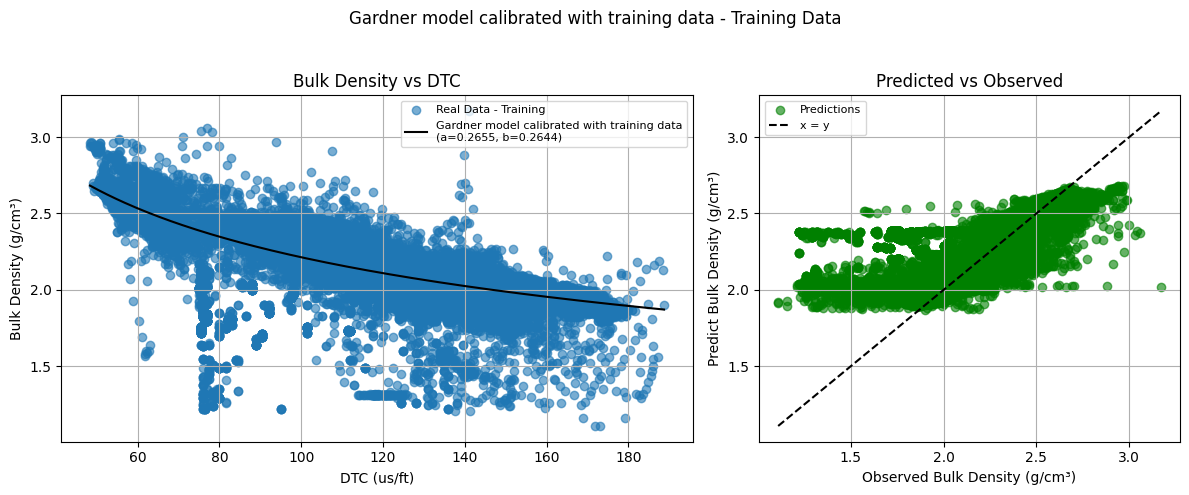

Metrics - Gardner model calibrated with training data - Training Data
R²: 0.6655
MSE: 0.0180
SSE: 1037.3501


/tmp/ipython-input-224-1225550520.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_modelo[nome_coluna_predita] = y_predito


In [ ]:
df_train, met_gardner_train = avaliar_modelo_regressao(rho_gardner_train, df_train, titulo= 'Gardner model calibrated with training data - Training Data',
                                                       nome_modelo = "Gardner", tipo_dado = "Training")

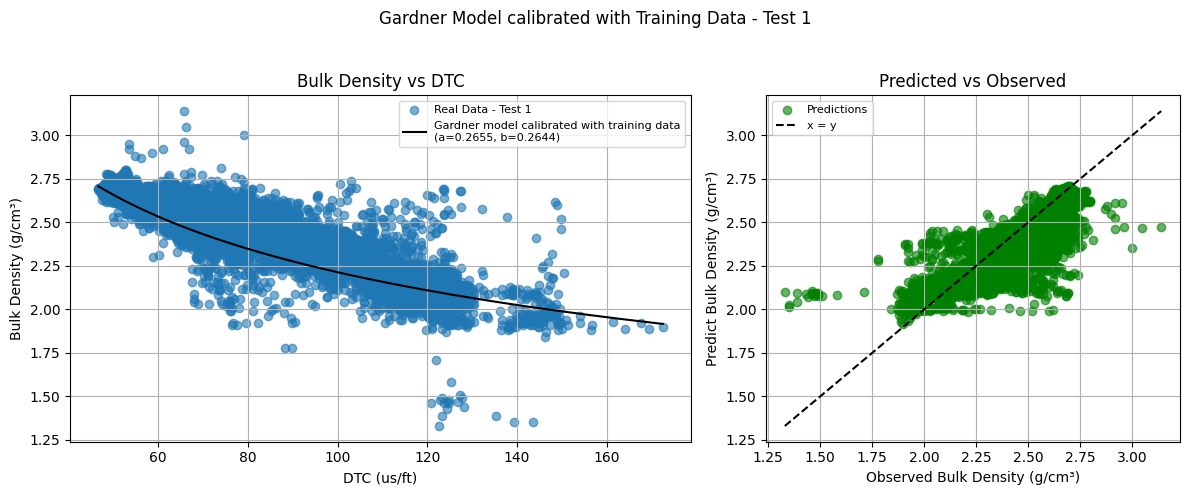

Metrics - Gardner Model calibrated with Training Data - Test 1
R²: 0.7259
MSE: 0.0140
SSE: 187.0401


/tmp/ipython-input-224-1225550520.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_modelo[nome_coluna_predita] = y_predito


In [ ]:
df_test1, met_gardner_test1 = avaliar_modelo_regressao(rho_gardner_test1, df_test1, titulo= 'Gardner Model calibrated with Training Data - Test 1',
                                                       nome_modelo = "Gardner", tipo_dado = "Test 1")

In [ ]:
dataset_original['Interpreted Lithology (system)'] = dataset_original['Interpreted Lithology (system)'].str.strip().str.title()


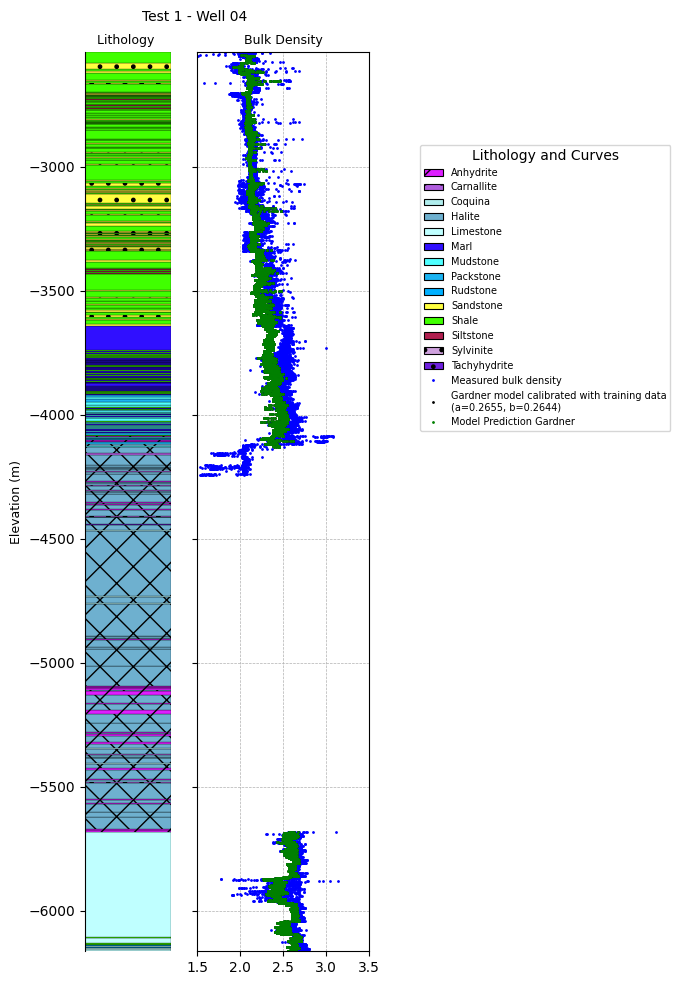

In [ ]:
dados_test1_Gardner = {
    'Bulk Density': rho_gardner_test1,
    'Elevation': df_test1["Elevation"],
    'DTC': df_test1["DTC"],
    'titulo_grafico': 'Test 1 - Well 04',
    'legenda_modelo': 'Gardner'
}

pocotest1 = df_test1['Well'].iloc[0]

plotar_litologia_e_densidade_Modelo(
    dataset_original[dataset_original['Well'] == pocotest1],
    dados_test1_Gardner
)

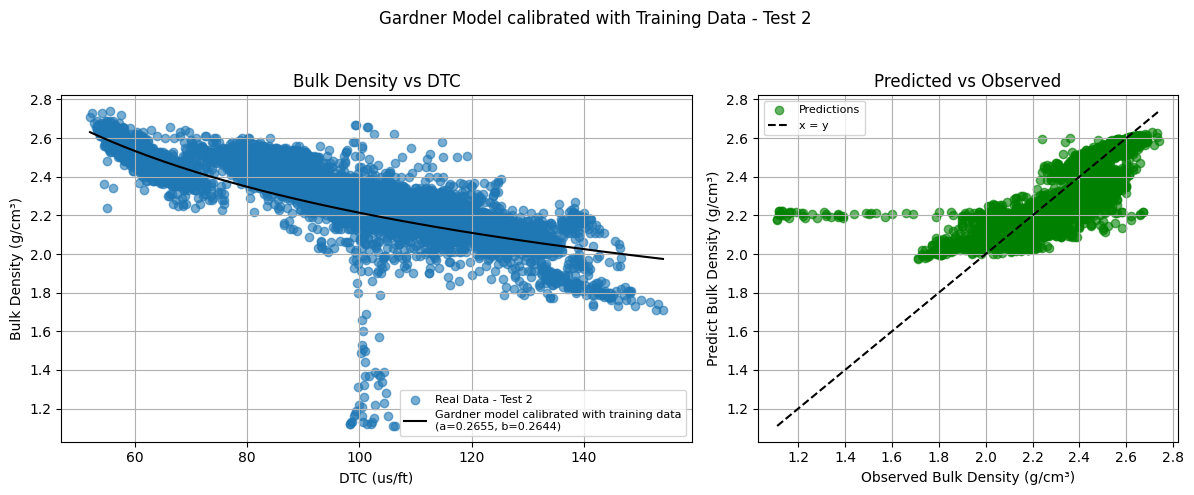

Metrics - Gardner Model calibrated with Training Data - Test 2
R²: 0.6306
MSE: 0.0138
SSE: 135.1349


/tmp/ipython-input-224-1225550520.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_modelo[nome_coluna_predita] = y_predito


In [ ]:
df_test2, met_gardner_test = avaliar_modelo_regressao(rho_gardner_test2, df_test2, titulo= 'Gardner Model calibrated with Training Data - Test 2',
                                                     nome_modelo = "Gardner", tipo_dado = "Test 2")

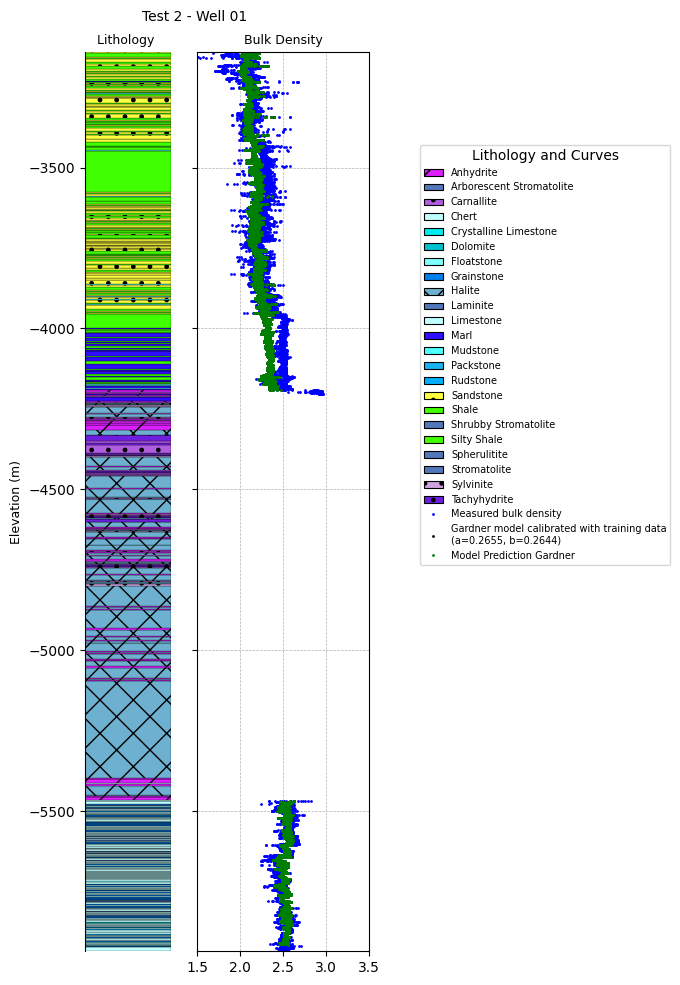

In [ ]:
dados_test2_Gardner = {
    'Bulk Density': rho_gardner_test2,
    'Elevation': df_test2["Elevation"],
    'DTC': df_test2["DTC"],
    'titulo_grafico': 'Test 2 - Well 01',
    'legenda_modelo': 'Gardner'
}

pocotest2 = df_test2['Well'].iloc[0]

plotar_litologia_e_densidade_Modelo(
    dataset_original[dataset_original['Well'] == pocotest2],
    dados_test2_Gardner
)

# **SVR**



## **Seleção de Topologia**

In [ ]:
from sklearn import svm

ModeloSVM = svm.SVR() #cria um objeto

In [ ]:
parametrosSVM = [{'C':[0.2,0.5,1],
               'kernel':["linear","sigmoid","rbf", "poly"]}]

In [ ]:
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(estimator=ModeloSVM,
                    param_grid=parametrosSVM,
                    cv=5,
                    verbose=2)
grid.fit(train_entn, train_sain)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ...............................C=0.2, kernel=linear; total time= 2.0min
[CV] END ...............................C=0.2, kernel=linear; total time=  10.3s
[CV] END ...............................C=0.2, kernel=linear; total time= 2.6min
[CV] END ...............................C=0.2, kernel=linear; total time=   6.1s
[CV] END ...............................C=0.2, kernel=linear; total time= 3.0min
[CV] END ..............................C=0.2, kernel=sigmoid; total time=13.9min
[CV] END ..............................C=0.2, kernel=sigmoid; total time=12.3min
[CV] END ..............................C=0.2, kernel=sigmoid; total time= 9.4min
[CV] END ..............................C=0.2, kernel=sigmoid; total time= 9.6min
[CV] END ..............................C=0.2, kernel=sigmoid; total time= 9.8min
[CV] END ..................................C=0.2, kernel=rbf; total time=   9.9s
[CV] END ..................................C=0.2

GridSearchCV(cv=5, estimator=SVR(),
             param_grid=[{'C': [0.2, 0.5, 1],
                          'kernel': ['linear', 'sigmoid', 'rbf', 'poly']}],
             verbose=2)

In [ ]:
pd.DataFrame(grid.cv_results_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  param_C  \
0       94.665112     73.625024         0.970500        0.419572      0.2   
1      613.123806    106.109405        46.078560        0.605252      0.2   
2       45.505424     78.571188         2.167842        0.691553      0.2   
3       72.636108     83.784271         0.941386        0.171295      0.2   
4        8.887070      1.630079         0.982608        0.330190      0.5   
5      476.678307     77.139181        46.319935        0.799749      0.5   
6       91.961111    104.682641         1.709999        0.497624      0.5   
7       58.576042     64.463035         0.870976        0.286061      0.5   
8        8.858486      2.509862         1.051013        0.360082      1.0   
9      541.735479    157.459212        46.659971        0.741126      1.0   
10      75.203387     84.933715         1.760326        0.409469      1.0   
11      44.111271     73.770027         0.737825        0.142979      1.0   

   param_kernel                           params  split0_test_score  \
0        linear   {'C': 0.2, 'kernel': 'linear'}           0.821577   
1       sigmoid  {'C': 0.2, 'kernel': 'sigmoid'}      -31683.962355   
2           rbf      {'C': 0.2, 'kernel': 'rbf'}           0.781990   
3          poly     {'C': 0.2, 'kernel': 'poly'}           0.763371   
4        linear   {'C': 0.5, 'kernel': 'linear'}           0.821729   
5       sigmoid  {'C': 0.5, 'kernel': 'sigmoid'}     -197767.832477   
6           rbf      {'C': 0.5, 'kernel': 'rbf'}           0.780552   
7          poly     {'C': 0.5, 'kernel': 'poly'}           0.739586   
8        linear     {'C': 1, 'kernel': 'linear'}           0.821493   
9       sigmoid    {'C': 1, 'kernel': 'sigmoid'}     -791378.393822   
10          rbf        {'C': 1, 'kernel': 'rbf'}           0.784959   
11         poly       {'C': 1, 'kernel': 'poly'}           0.718688   

    split1_test_score  split2_test_score  split3_test_score  \
0        1.726753e-01       7.809896e-01       2.791966e-01   
1       -4.939785e+05      -6.164211e+04      -6.139521e+04   
2        7.090533e-02       7.705362e-01       2.621507e-01   
3       -5.971105e-02       7.695858e-01      -9.646785e-02   
4        1.686358e-01       7.812149e-01       2.712501e-01   
5       -3.082355e+06      -3.856312e+05      -3.838904e+05   
6        9.218189e-02       7.677927e-01       2.775076e-01   
7        5.232811e-02       7.660445e-01      -1.633023e-01   
8        1.739416e-01       7.809921e-01       2.738989e-01   
9       -1.232949e+07      -1.543550e+06      -1.535742e+06   
10       6.148561e-02       7.555544e-01       2.500024e-01   
11       1.019534e-02       7.510911e-01      -2.373068e-01   

    split4_test_score  mean_test_score  std_test_score  rank_test_score  
0        3.803810e-01     4.869638e-01    2.652249e-01                1  
1       -8.068149e+04    -1.458763e+05    1.747558e+05               10  
2        3.307550e-01     4.432675e-01    2.849399e-01                5  
3        2.360462e-01     3.225648e-01    3.803542e-01                7  
4        3.789957e-01     4.843652e-01    2.676341e-01                3  
5       -5.032461e+05    -9.105781e+05    1.090285e+06               11  
6        3.254619e-01     4.486992e-01    2.769642e-01                4  
7        1.868578e-01     3.163029e-01    3.736031e-01                8  
8        3.824273e-01     4.865505e-01    2.655820e-01                2  
9       -2.013470e+06    -3.642726e+06    4.360974e+06               12  
10       3.277906e-01     4.359585e-01    2.865146e-01                6  
11       1.901975e-01     2.865730e-01    3.905440e-01                9

In [ ]:
resultados = pd.DataFrame(grid.cv_results_)[['params','rank_test_score','mean_test_score']]
resultados = resultados.sort_values(by='rank_test_score')
resultados

params  rank_test_score  mean_test_score
0    {'C': 0.2, 'kernel': 'linear'}                1     4.869638e-01
8      {'C': 1, 'kernel': 'linear'}                2     4.865505e-01
4    {'C': 0.5, 'kernel': 'linear'}                3     4.843652e-01
6       {'C': 0.5, 'kernel': 'rbf'}                4     4.486992e-01
2       {'C': 0.2, 'kernel': 'rbf'}                5     4.432675e-01
10        {'C': 1, 'kernel': 'rbf'}                6     4.359585e-01
3      {'C': 0.2, 'kernel': 'poly'}                7     3.225648e-01
7      {'C': 0.5, 'kernel': 'poly'}                8     3.163029e-01
11       {'C': 1, 'kernel': 'poly'}                9     2.865730e-01
1   {'C': 0.2, 'kernel': 'sigmoid'}               10    -1.458763e+05
5   {'C': 0.5, 'kernel': 'sigmoid'}               11    -9.105781e+05
9     {'C': 1, 'kernel': 'sigmoid'}               12    -3.642726e+06

In [ ]:
print("Melhores parâmetros:", grid.best_params_)

Melhores parâmetros: {'C': 0.2, 'kernel': 'linear'}


## **Treinamento**

In [ ]:
#Especificar a topologia do modelo

from sklearn import svm

ModeloSVM = svm.SVR(C=0.2,
                kernel='linear')

ModeloSVM.fit(train_entn, train_sain) #ajuste do modelo pelos dados de entrada e comparando com os de saída

SVR(C=0.2, kernel='linear')

In [ ]:
y_predictn = pd.DataFrame(ModeloSVM.predict(train_entn))  #Uso dos dados de entrada normalizados para predição pelo modelo.

#y_predictn

In [ ]:
#Desnormalização dos dados
y_predict = scaler2.inverse_transform(y_predictn) #Usando os valores máximos e mínimos definidos pelos vetores reais.
y_predict = np.ravel(y_predict)
print(pd.DataFrame(y_predict))

              0
0      2.090383
1      2.096153
2      2.097198
3      2.093097
4      2.085193
...         ...
57656  2.507560
57657  2.507069
57658  2.506424
57659  2.506087
57660  2.505865

[57661 rows x 1 columns]


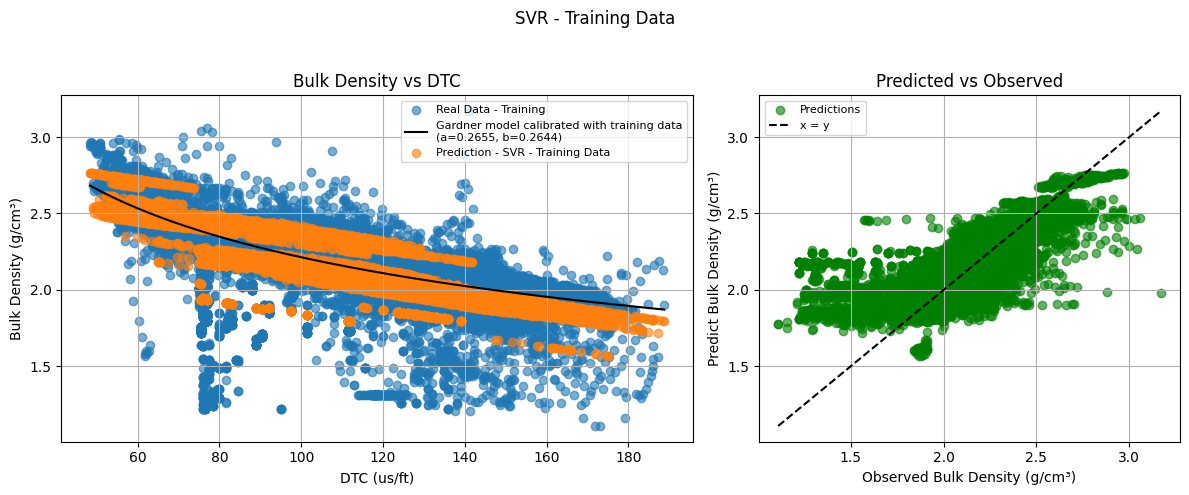

Metrics - SVR - Training Data
R²: 0.7376
MSE: 0.0141
SSE: 813.7270


/tmp/ipython-input-224-1225550520.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_modelo[nome_coluna_predita] = y_predito


In [ ]:
df_train, met_svm_train = avaliar_modelo_regressao(y_predict, df_train, titulo= 'SVR - Training Data', nome_modelo = "SVR", tipo_dado = "Training")

## **Teste 1**

In [ ]:
y_predict2n = pd.DataFrame(ModeloSVM.predict(test1_entn))
y_predict2n

0
0      0.423444
1      0.431260
2      0.438778
3      0.452095
4      0.454486
...         ...
13369  0.680088
13370  0.696518
13371  0.696149
13372  0.695930
13373  0.695840

[13374 rows x 1 columns]

In [ ]:
#Desnormalização dados de teste 1
y_predict2 = scaler2.inverse_transform(y_predict2n) #Usando o valores máximos e mínimos definidos pelos vetores reais.
y_predict2 = np.ravel(y_predict2)
print(pd.DataFrame(y_predict2))

              0
0      1.982294
1      1.998396
2      2.013883
3      2.041316
4      2.046241
...         ...
13369  2.510982
13370  2.544827
13371  2.544067
13372  2.543615
13373  2.543431

[13374 rows x 1 columns]


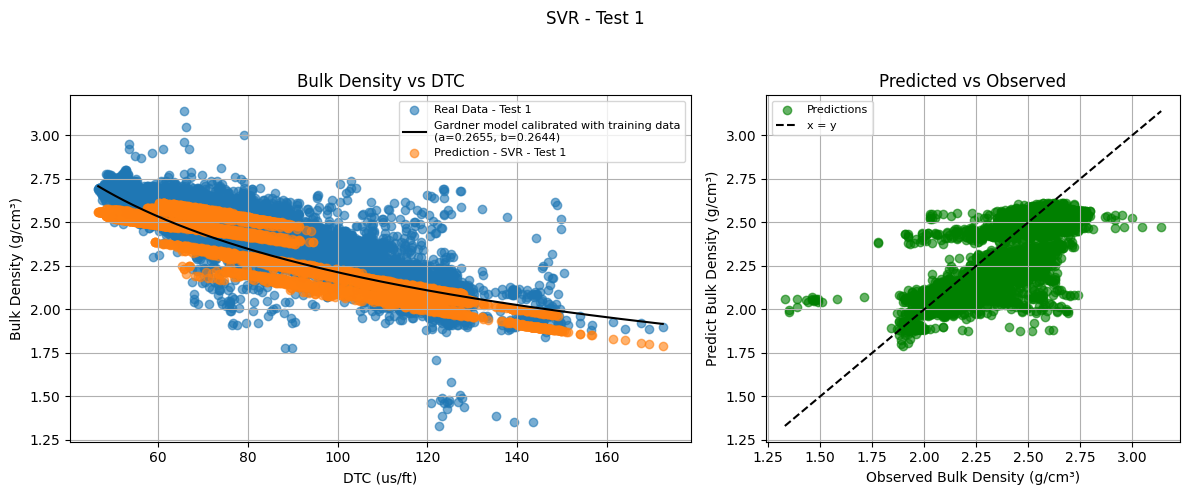

Metrics - SVR - Test 1
R²: 0.6725
MSE: 0.0167
SSE: 223.4564


/tmp/ipython-input-224-1225550520.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_modelo[nome_coluna_predita] = y_predito


In [ ]:
df_test1, met_svm_test1 = avaliar_modelo_regressao(y_predict2, df_test1, titulo= 'SVR - Test 1', nome_modelo = "SVR", tipo_dado = "Test 1")

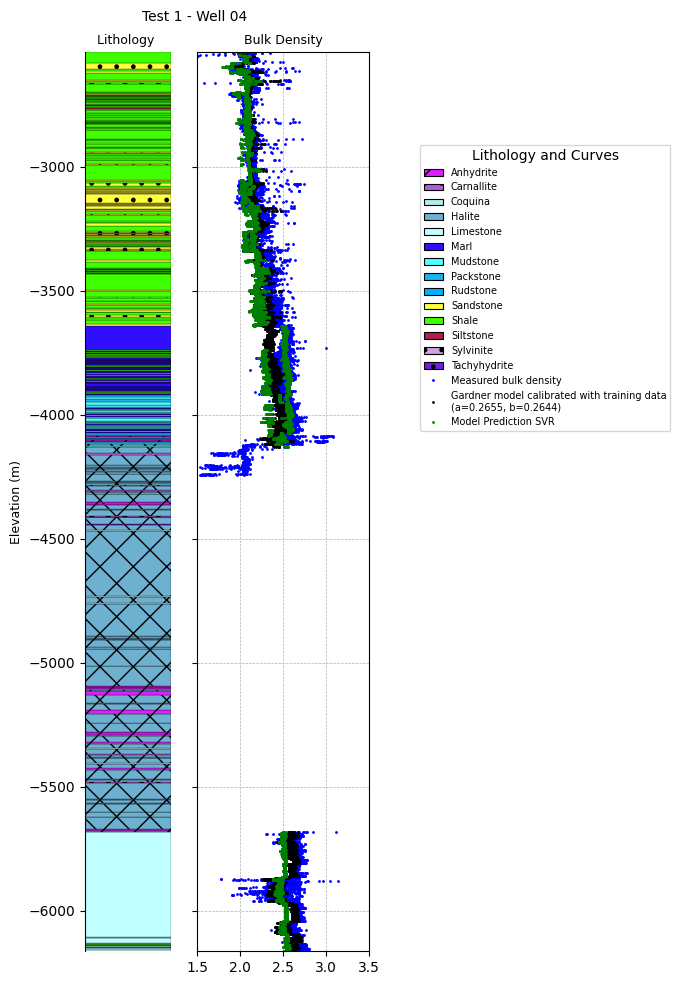

In [ ]:
dados_test1_SVM = {
    'Bulk Density': y_predict2,
    'Elevation': df_test1["Elevation"],
    'DTC': df_test1["DTC"],
    'titulo_grafico': 'Test 1 - Well 04',
    'legenda_modelo': 'SVR'
}

pocotest1 = df_test1['Well'].iloc[0]

plotar_litologia_e_densidade_Modelo(
    dataset_original[dataset_original['Well'] == pocotest1],
    dados_test1_SVM
)

## **Teste 2**

In [ ]:
y_final2predictn = pd.DataFrame(ModeloSVM.predict(test2_entn))
y_final2predictn

0
0     0.464181
1     0.463514
2     0.461411
3     0.460651
4     0.463135
...        ...
9802  0.670187
9803  0.670228
9804  0.670251
9805  0.670255
9806  0.670278

[9807 rows x 1 columns]

In [ ]:
#Desnormalização dados de teste 2
y_final2predict = scaler2.inverse_transform(y_final2predictn) #Usando o valores máximos e mínimos definidos pelos vetores reais.
y_final2predict = np.ravel(y_final2predict)
print(pd.DataFrame(y_final2predict))

             0
0     2.066213
1     2.064839
2     2.060507
3     2.058940
4     2.064057
...        ...
9802  2.490585
9803  2.490670
9804  2.490717
9805  2.490725
9806  2.490772

[9807 rows x 1 columns]


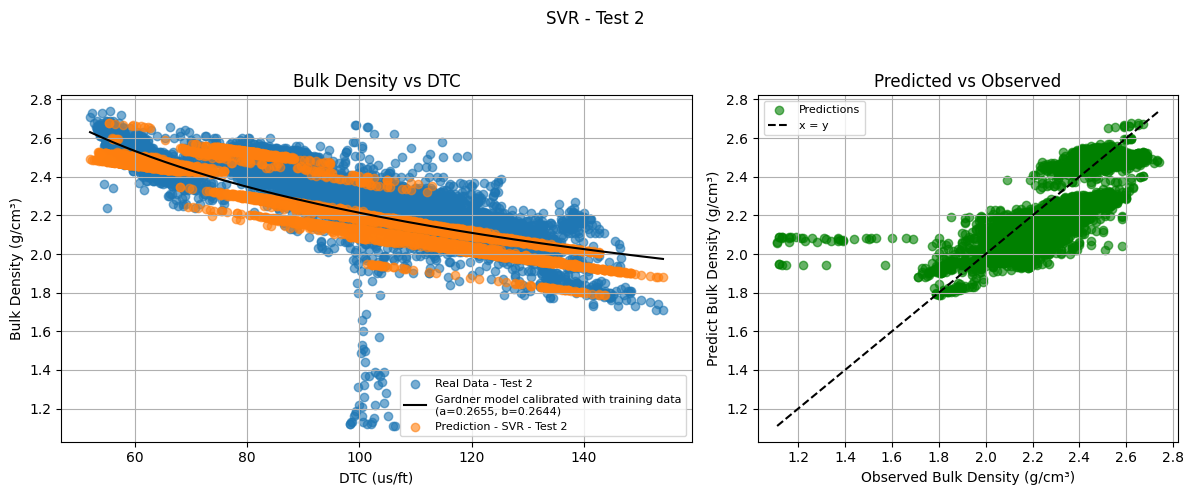

Metrics - SVR - Test 2
R²: 0.5740
MSE: 0.0159
SSE: 155.8184


/tmp/ipython-input-224-1225550520.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_modelo[nome_coluna_predita] = y_predito


In [ ]:
df_test2, met_svm_test2 = avaliar_modelo_regressao(y_final2predict, df_test2, titulo= 'SVR - Test 2', nome_modelo = "SVR", tipo_dado = "Test 2")

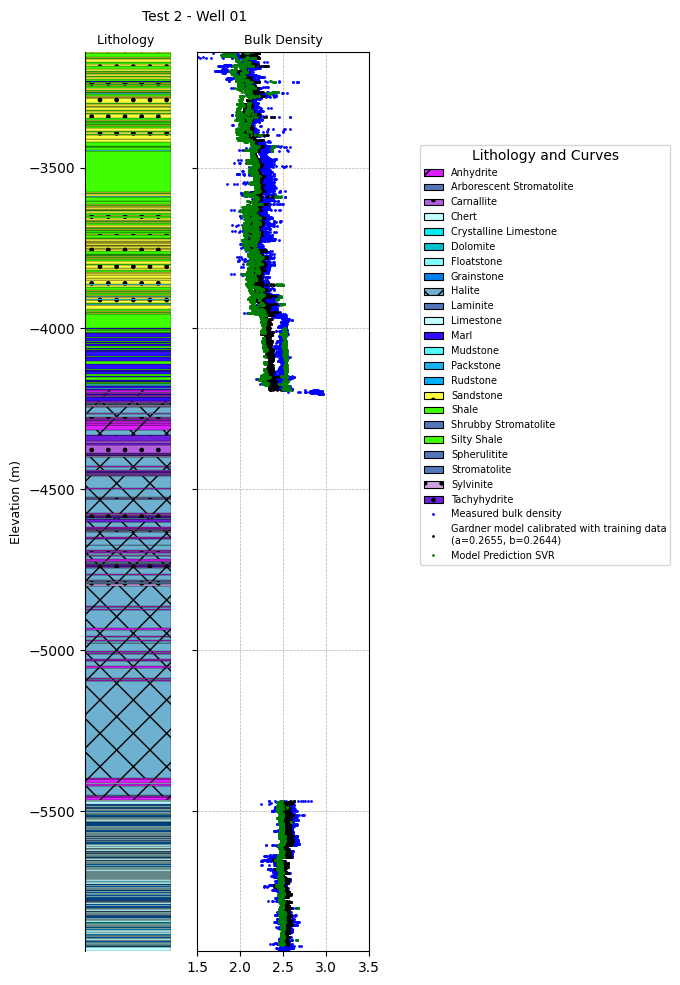

In [ ]:
dados_test2_SVM = {
    'Bulk Density': y_final2predict,
    'Elevation': df_test2["Elevation"],
    'DTC': df_test2["DTC"],
    'titulo_grafico': 'Test 2 - Well 01',
    'legenda_modelo': 'SVR'
}

pocotest2 = df_test2['Well'].iloc[0]

plotar_litologia_e_densidade_Modelo(
    dataset_original[dataset_original['Well'] == pocotest2],
    dados_test2_SVM
)

# **Árvore de Decisão**

## **Seleção de Topologia**

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
ModeloAD = tree.DecisionTreeRegressor() #o parâmetro max_iter não é válido para o DecisionTreeRegressor do sklearn.tree

In [ ]:
parametrosAD = [{'criterion':["squared_error", "friedman_mse","absolute_error"],
               'max_depth':[3,5, None],
               'min_samples_split':[2,4],
               'min_samples_leaf':[1,3,5]}]

In [ ]:
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(estimator = ModeloAD,
                    param_grid = parametrosAD,
                    cv=5,
                    verbose=2)
grid.fit(train_entn, train_sain)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] END criterion=squared_error, max_depth=3, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END criterion=squared_error, max_depth=3, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END criterion=squared_error, max_depth=3, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END criterion=squared_error, max_depth=3, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END criterion=squared_error, max_depth=3, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END criterion=squared_error, max_depth=3, min_samples_leaf=1, min_samples_split=4; total time=   0.1s
[CV] END criterion=squared_error, max_depth=3, min_samples_leaf=1, min_samples_split=4; total time=   0.1s
[CV] END criterion=squared_error, max_depth=3, min_samples_leaf=1, min_samples_split=4; total time=   0.1s
[CV] END criterion=squared_error, max_depth=3, min_samples_leaf=1, min_samples_spl

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid=[{'criterion': ['squared_error', 'friedman_mse',
                                        'absolute_error'],
                          'max_depth': [3, 5, None],
                          'min_samples_leaf': [1, 3, 5],
                          'min_samples_split': [2, 4]}],
             verbose=2)

In [ ]:
resultados = pd.DataFrame(grid.cv_results_)[['params','rank_test_score','mean_test_score']]
resultados = resultados.sort_values(by='rank_test_score')
resultados

params  rank_test_score  \
46  {'criterion': 'absolute_error', 'max_depth': 5...                1   
47  {'criterion': 'absolute_error', 'max_depth': 5...                2   
42  {'criterion': 'absolute_error', 'max_depth': 5...                3   
43  {'criterion': 'absolute_error', 'max_depth': 5...                4   
44  {'criterion': 'absolute_error', 'max_depth': 5...                5   
45  {'criterion': 'absolute_error', 'max_depth': 5...                6   
24  {'criterion': 'friedman_mse', 'max_depth': 5, ...                7   
6   {'criterion': 'squared_error', 'max_depth': 5,...                8   
29  {'criterion': 'friedman_mse', 'max_depth': 5, ...                9   
28  {'criterion': 'friedman_mse', 'max_depth': 5, ...               10   
11  {'criterion': 'squared_error', 'max_depth': 5,...               11   
10  {'criterion': 'squared_error', 'max_depth': 5,...               12   
25  {'criterion': 'friedman_mse', 'max_depth': 5, ...               13   
7   {'criterion': 'squared_error', 'max_depth': 5,...               14   
27  {'criterion': 'friedman_mse', 'max_depth': 5, ...               15   
8   {'criterion': 'squared_error', 'max_depth': 5,...               16   
26  {'criterion': 'friedman_mse', 'max_depth': 5, ...               17   
9   {'criterion': 'squared_error', 'max_depth': 5,...               18   
38  {'criterion': 'absolute_error', 'max_depth': 3...               19   
39  {'criterion': 'absolute_error', 'max_depth': 3...               19   
41  {'criterion': 'absolute_error', 'max_depth': 3...               19   
40  {'criterion': 'absolute_error', 'max_depth': 3...               19   
37  {'criterion': 'absolute_error', 'max_depth': 3...               19   
36  {'criterion': 'absolute_error', 'max_depth': 3...               19   
22  {'criterion': 'friedman_mse', 'max_depth': 3, ...               25   
4   {'criterion': 'squared_error', 'max_depth': 3,...               26   
23  {'criterion': 'friedman_mse', 'max_depth': 3, ...               27   
1   {'criterion': 'squared_error', 'max_depth': 3,...               28   
5   {'criterion': 'squared_error', 'max_depth': 3,...               29   
2   {'criterion': 'squared_error', 'max_depth': 3,...               30   
18  {'criterion': 'friedman_mse', 'max_depth': 3, ...               31   
3   {'criterion': 'squared_error', 'max_depth': 3,...               32   
19  {'criterion': 'friedman_mse', 'max_depth': 3, ...               33   
0   {'criterion': 'squared_error', 'max_depth': 3,...               34   
20  {'criterion': 'friedman_mse', 'max_depth': 3, ...               35   
21  {'criterion': 'friedman_mse', 'max_depth': 3, ...               36   
34  {'criterion': 'friedman_mse', 'max_depth': Non...               37   
35  {'criterion': 'friedman_mse', 'max_depth': Non...               38   
17  {'criterion': 'squared_error', 'max_depth': No...               39   
16  {'criterion': 'squared_error', 'max_depth': No...               40   
15  {'criterion': 'squared_error', 'max_depth': No...               41   
32  {'criterion': 'friedman_mse', 'max_depth': Non...               42   
33  {'criterion': 'friedman_mse', 'max_depth': Non...               43   
14  {'criterion': 'squared_error', 'max_depth': No...               44   
13  {'criterion': 'squared_error', 'max_depth': No...               45   
49  {'criterion': 'absolute_error', 'max_depth': N...               46   
31  {'criterion': 'friedman_mse', 'max_depth': Non...               47   
12  {'criterion': 'squared_error', 'max_depth': No...               48   
48  {'criterion': 'absolute_error', 'max_depth': N...               49   
30  {'criterion': 'friedman_mse', 'max_depth': Non...               50   
50  {'criterion': 'absolute_error', 'max_depth': N...               51   
51  {'criterion': 'absolute_error', 'max_depth': N...               52   
52  {'criterion': 'absolute_error', 'max_depth': N...               53   
53  {'criterion': 'absolute_error', 'max_depth': N.

In [ ]:
print("Melhores parâmetros:", grid.best_params_)

Melhores parâmetros: {'criterion': 'absolute_error', 'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 2}


## **Treinamento**

Atenção!!!

Foram feitos testes com as combinações presentes nos top 10 do rank, para selecionar o melhor resultado combinado de R2, considerando o treinamento, teste 1 e teste 2, conforme segue:

### Desempenho das Árvores de Decisão Avaliadas

| Criterion         | Max Depth | Min Samples Leaf | Min Samples Split | Conjunto     | R²       | MSE       | SSE       |
|-------------------|-----------|-------------------|-------------------|--------------|---------|----------|---------|
| ⭐ absolute_error  | 5         | 5                 | 2                 | Treinamento  | 0.7922  | 0.0112   | 644.28  |
|                   |           |                   |                   | Teste 1      | 0.6683  | 0.0169   | 226.33  |
|                   |           |                   |                   | Teste 2      | 0.5652  | 0.0162   | 159.06  |
| absolute_error    | 5         | 5                 | 4                 | Treinamento  | 0.7922  | 0.0112   | 644.28  |
|                   |           |                   |                   | Teste 1      | 0.6683  | 0.0169   | 226.33  |
|                   |           |                   |                   | Teste 2      | 0.5652  | 0.0162   | 159.05  |
| absolute_error    | 5         | 1                 | 2                 | Treinamento  | 0.7922  | 0.0112   | 644.28  |
|                   |           |                   |                   | Teste 1      | 0.6683  | 0.0169   | 226.33  |
|                   |           |                   |                   | Teste 2      | 0.5652  | 0.0162   | 159.05  |
| absolute_error    | 5         | 1                 | 4                 | Treinamento  | 0.7922  | 0.0112   | 644.28  |
|                   |           |                   |                   | Teste 1      | 0.6683  | 0.0169   | 226.33  |
|                   |           |                   |                   | Teste 2      | 0.5652  | 0.0162   | 159.06  |
| absolute_error    | 5         | 3                 | 2                 | Treinamento  | 0.7922  | 0.0112   | 644.28  |
|                   |           |                   |                   | Teste 1      | 0.6683  | 0.0169   | 226.33  |
|                   |           |                   |                   | Teste 2      | 0.5652  | 0.0162   | 159.06  |
| absolute_error    | 5         | 3                 | 4                 | Treinamento  | 0.7922  | 0.0112   | 644.28  |
|                   |           |                   |                   | Teste 1      | 0.6683  | 0.0169   | 226.33  |
|                   |           |                   |                   | Teste 2      | 0.5652  | 0.0162   | 159.05  |
| friedman_mse      | 5         | 1                 | 2                 | Treinamento  | 0.7966  | 0.0109   | 630.74  |
|                   |           |                   |                   | Teste 1      | 0.6141  | 0.0197   | 263.30  |
|                   |           |                   |                   | Teste 2      | 0.4621  | 0.0201   | 196.76  |
| squared_error     | 5         | 1                 | 2                 | Treinamento  | 0.7966  | 0.0109   | 630.74  |
|                   |           |                   |                   | Teste 1      | 0.6141  | 0.0197   | 263.30  |
|                   |           |                   |                   | Teste 2      | 0.4621  | 0.0201   | 196.76  |
| friedman_mse      | 5         | 5                 | 4                 | Treinamento  | 0.7966  | 0.0109   | 630.74  |
|                   |           |                   |                   | Teste 1      | 0.6141  | 0.0197   | 263.30  |
|                   |           |                   |                   | Teste 2      | 0.4621  | 0.0201   | 196.76  |
| friedman_mse      | 5         | 5                 | 2                 | Treinamento  | 0.7966  | 0.0109   | 630.74  |
|                   |           |                   |                   | Teste 1      | 0.6141  | 0.0197   | 263.30  |
|                   |           |                   |                   | Teste 2      | 0.4621  | 0.0201   | 196.76  |

---

⭐ **Modelo escolhido:**  
`criterion = absolute_error`, `max_depth = 5`, `min_samples_leaf = 5`, `min_samples_split = 2`

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree

ModeloAD = DecisionTreeRegressor(criterion="absolute_error",
                              max_depth=5,
                              min_samples_split=2,
                              min_samples_leaf=5)

ModeloAD.fit(train_entn, train_sain)

DecisionTreeRegressor(criterion='absolute_error', max_depth=5,
                      min_samples_leaf=5)

In [ ]:
from sklearn.tree import export_graphviz
from sklearn import tree

dot_data = tree.export_graphviz(ModeloAD, #feature_names=train_ent.columns
                                 filled=True)

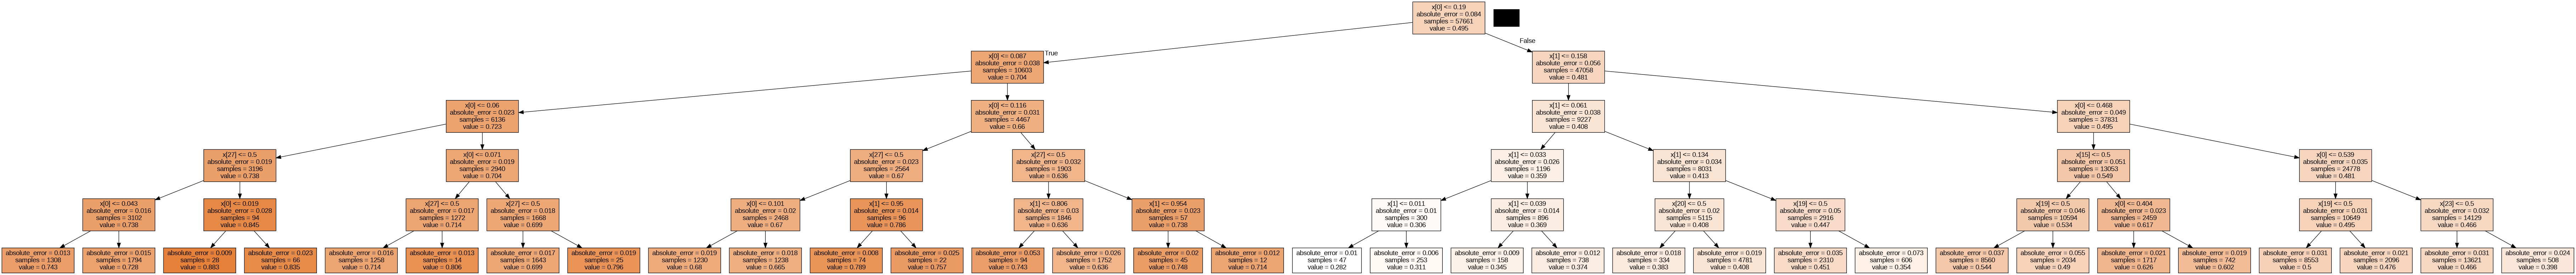

In [ ]:
import pydotplus
from IPython.display import Image
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [ ]:
y_predictn = pd.DataFrame(ModeloAD.predict(train_entn))  #Uso dos dados de entrada normalizados para predição pelo modelo.

#y_predictn

In [ ]:
#Desnormalização dos dados
y_predict = scaler2.inverse_transform(y_predictn) #Usando o valores máximos e mínimos definidos pelos vetores reais.
y_predict = np.ravel(y_predict)
print(pd.DataFrame(y_predict))

          0
0      2.14
1      2.14
2      2.14
3      2.14
4      2.14
...     ...
57656  2.55
57657  2.55
57658  2.55
57659  2.55
57660  2.55

[57661 rows x 1 columns]


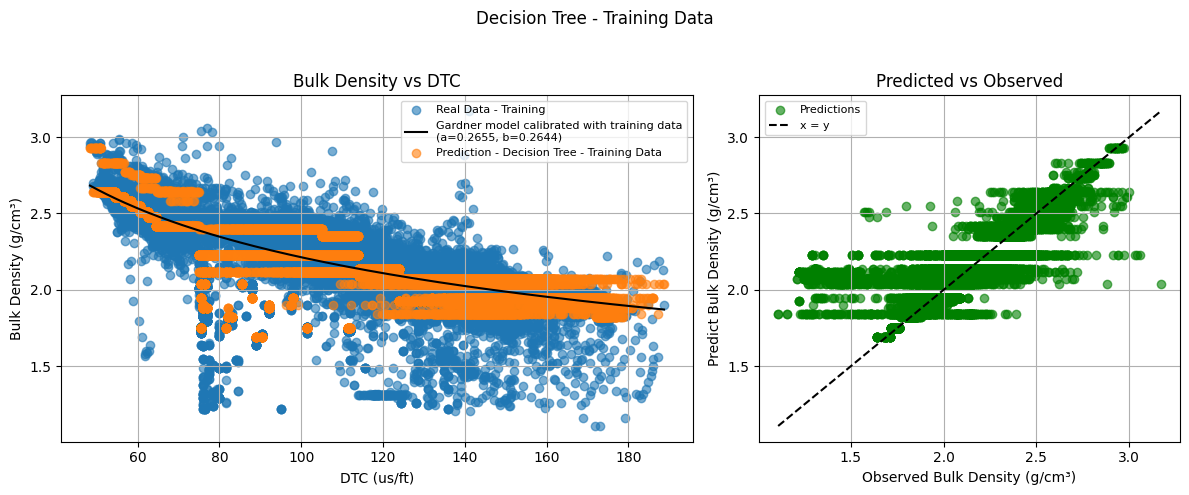

Metrics - Decision Tree - Training Data
R²: 0.7922
MSE: 0.0112
SSE: 644.2778


/tmp/ipython-input-224-1225550520.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_modelo[nome_coluna_predita] = y_predito


In [ ]:
df_train, met_ad_train = avaliar_modelo_regressao(y_predict, df_train, titulo= 'Decision Tree - Training Data', nome_modelo = "DT", tipo_dado = "Training")

## **Teste 1**

In [ ]:
y_predict2n = pd.DataFrame(ModeloAD.predict(test1_entn))
y_predict2n

0
0      0.466019
1      0.466019
2      0.466019
3      0.466019
4      0.466019
...         ...
13369  0.713592
13370  0.713592
13371  0.713592
13372  0.713592
13373  0.699029

[13374 rows x 1 columns]

In [ ]:
#Desnormalização dados de teste 1
y_predict2 = scaler2.inverse_transform(y_predict2n) #Usando o valores máximos e mínimos definidos pelos vetores reais.
y_predict2 = np.ravel(y_predict2)
print(pd.DataFrame(y_predict2))

          0
0      2.07
1      2.07
2      2.07
3      2.07
4      2.07
...     ...
13369  2.58
13370  2.58
13371  2.58
13372  2.58
13373  2.55

[13374 rows x 1 columns]


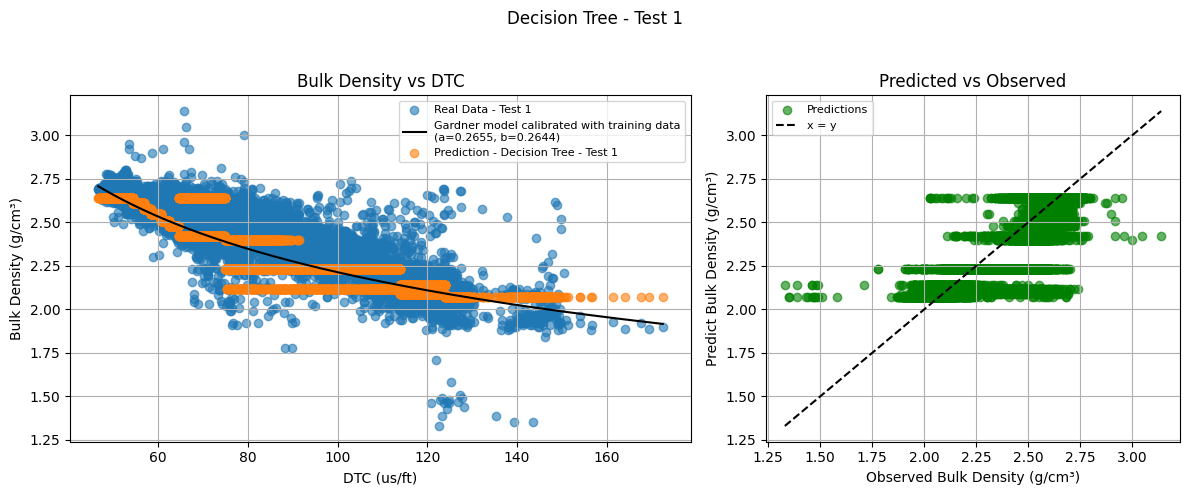

Metrics - Decision Tree - Test 1
R²: 0.6683
MSE: 0.0169
SSE: 226.3281


/tmp/ipython-input-224-1225550520.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_modelo[nome_coluna_predita] = y_predito


In [ ]:
df_test1, met_ad_test1 = avaliar_modelo_regressao(y_predict2, df_test1, titulo= 'Decision Tree - Test 1', nome_modelo = "DT", tipo_dado = "Test 1")

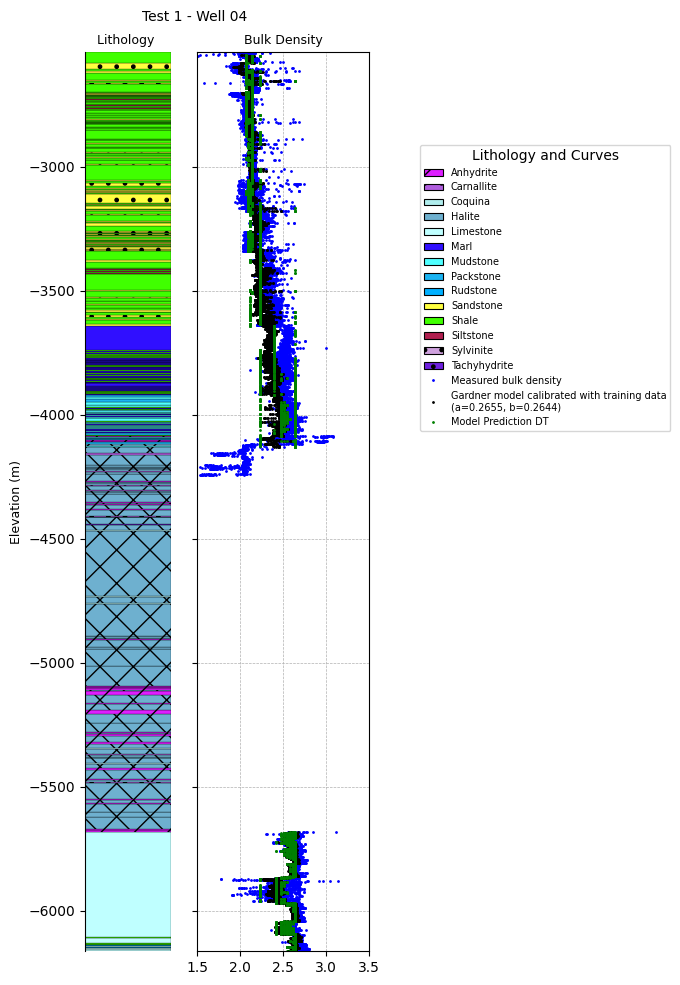

In [ ]:
dados_test1_AD = {
    'Bulk Density': y_predict2,
    'Elevation': df_test1["Elevation"],
    'DTC': df_test1["DTC"],
    'titulo_grafico': 'Test 1 - Well 04',
    'legenda_modelo': 'DT'
}

pocotest1 = df_test1['Well'].iloc[0]

plotar_litologia_e_densidade_Modelo(
    dataset_original[dataset_original['Well'] == pocotest1],
    dados_test1_AD
)

## **Teste 2**

In [ ]:
y_final2predictn = pd.DataFrame(ModeloAD.predict(test2_entn))
y_final2predictn

0
0     0.490291
1     0.490291
2     0.490291
3     0.490291
4     0.490291
...        ...
9802  0.713592
9803  0.713592
9804  0.713592
9805  0.713592
9806  0.713592

[9807 rows x 1 columns]

In [ ]:
#Desnormalização dados de teste 2
y_final2predict = scaler2.inverse_transform(y_final2predictn) #Usando o valores máximos e mínimos definidos pelos vetores reais.
y_final2predict = np.ravel(y_final2predict)
print(pd.DataFrame(y_final2predict))

         0
0     2.12
1     2.12
2     2.12
3     2.12
4     2.12
...    ...
9802  2.58
9803  2.58
9804  2.58
9805  2.58
9806  2.58

[9807 rows x 1 columns]


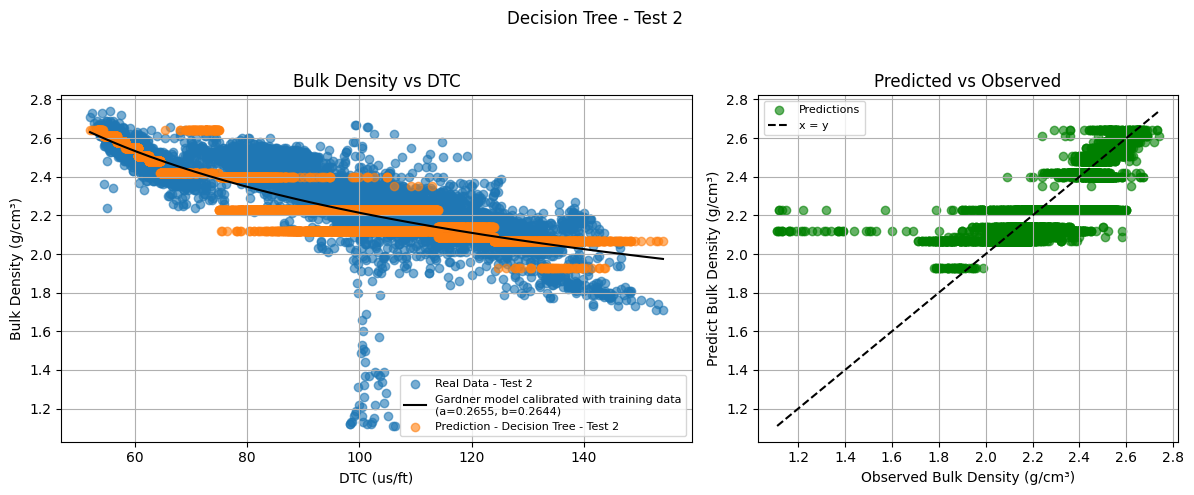

Metrics - Decision Tree - Test 2
R²: 0.5652
MSE: 0.0162
SSE: 159.0560


/tmp/ipython-input-224-1225550520.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_modelo[nome_coluna_predita] = y_predito


In [ ]:
df_test2, met_ad_test2 = avaliar_modelo_regressao(y_final2predict, df_test2, titulo= 'Decision Tree - Test 2', nome_modelo = "DT", tipo_dado = "Test 2")

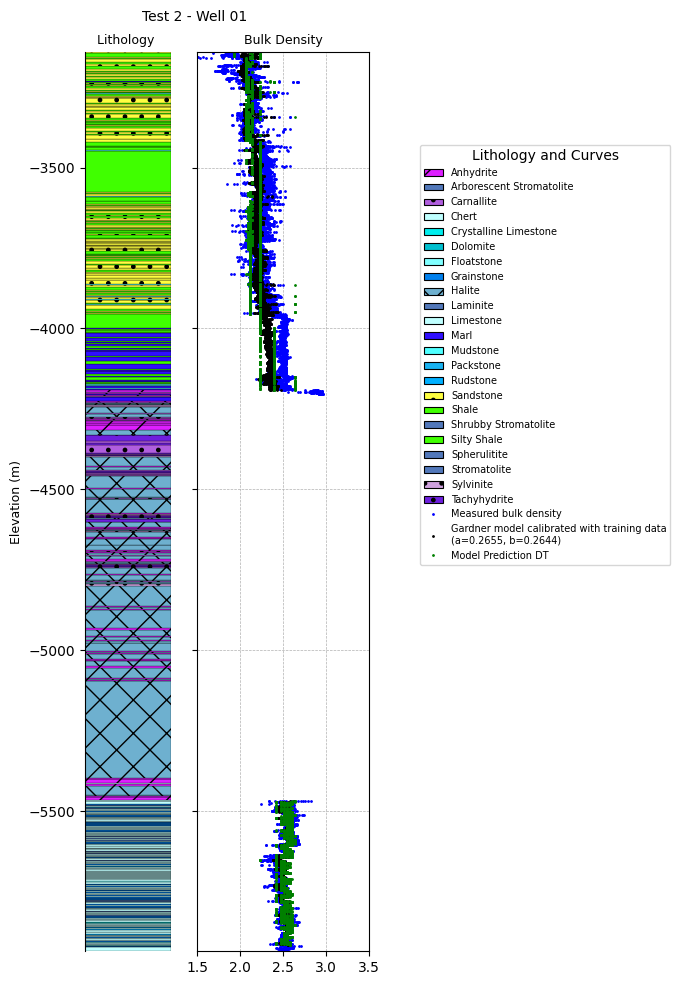

In [ ]:
dados_test2_AD = {
    'Bulk Density': y_final2predict,
    'Elevation': df_test2["Elevation"],
    'DTC': df_test2["DTC"],
    'titulo_grafico': 'Test 2 - Well 01',
    'legenda_modelo': 'DT'
}

pocotest2 = df_test2['Well'].iloc[0]

plotar_litologia_e_densidade_Modelo(
    dataset_original[dataset_original['Well'] == pocotest2],
    dados_test2_AD
)

# **Redes Neurais Artificiais**

##**Seleção de Topologia**

In [ ]:
from sklearn.neural_network import MLPRegressor

ModeloRNA = MLPRegressor() #cria um objeto

In [ ]:
parametrosRNA = [{'hidden_layer_sizes':[(6,), (9,), (12,), (50,), (100,), (6, 6), (30,20), (50, 25), (30, 20, 10)],
               'activation':["logistic","tanh", "relu"],
               'solver':["lbfgs","sgd","adam"],
               'learning_rate':["constant","adaptive"]}]

In [ ]:
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(estimator = ModeloRNA,
                    param_grid = parametrosRNA,
                    scoring = 'r2',
                    cv =5,
                    verbose=2)
grid.fit(train_entn, train_sain)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
[CV] END activation=logistic, hidden_layer_sizes=(6,), learning_rate=constant, solver=lbfgs; total time=   1.3s
[CV] END activation=logistic, hidden_layer_sizes=(6,), learning_rate=constant, solver=lbfgs; total time=   1.2s
[CV] END activation=logistic, hidden_layer_sizes=(6,), learning_rate=constant, solver=lbfgs; total time=   1.2s
[CV] END activation=logistic, hidden_layer_sizes=(6,), learning_rate=constant, solver=lbfgs; total time=   1.8s
[CV] END activation=logistic, hidden_layer_sizes=(6,), learning_rate=constant, solver=lbfgs; total time=   0.8s
[CV] END activation=logistic, hidden_layer_sizes=(6,), learning_rate=constant, solver=sgd; total time=   1.3s
[CV] END activation=logistic, hidden_layer_sizes=(6,), learning_rate=constant, solver=sgd; total time=   3.2s
[CV] END activation=logistic, hidden_layer_sizes=(6,), learning_rate=constant, solver=sgd; total time=   1.5s
[CV] END activation=logistic, hidden_layer_size

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=relu, hidden_layer_sizes=(30, 20, 10), learning_rate=adaptive, solver=lbfgs; total time=  45.6s
[CV] END activation=relu, hidden_layer_sizes=(30, 20, 10), learning_rate=adaptive, solver=lbfgs; total time=   6.1s
[CV] END activation=relu, hidden_layer_sizes=(30, 20, 10), learning_rate=adaptive, solver=lbfgs; total time=  11.7s
[CV] END activation=relu, hidden_layer_sizes=(30, 20, 10), learning_rate=adaptive, solver=lbfgs; total time=  10.1s
[CV] END activation=relu, hidden_layer_sizes=(30, 20, 10), learning_rate=adaptive, solver=sgd; total time=  14.5s
[CV] END activation=relu, hidden_layer_sizes=(30, 20, 10), learning_rate=adaptive, solver=sgd; total time=  14.9s
[CV] END activation=relu, hidden_layer_sizes=(30, 20, 10), learning_rate=adaptive, solver=sgd; total time=  14.7s
[CV] END activation=relu, hidden_layer_sizes=(30, 20, 10), learning_rate=adaptive, solver=sgd; total time=  13.6s
[CV] END activation=relu, hidden_layer_sizes=(30, 20, 10), learning_rate=adaptiv

GridSearchCV(cv=5, estimator=MLPRegressor(),
             param_grid=[{'activation': ['logistic', 'tanh', 'relu'],
                          'hidden_layer_sizes': [(6,), (9,), (12,), (50,),
                                                 (100,), (6, 6), (30, 20),
                                                 (50, 25), (30, 20, 10)],
                          'learning_rate': ['constant', 'adaptive'],
                          'solver': ['lbfgs', 'sgd', 'adam']}],
             scoring='r2', verbose=2)

In [ ]:
pd.DataFrame(grid.cv_results_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0         1.252981      0.323763         0.009620        0.003107   
1         1.861485      0.687739         0.006599        0.004242   
2         1.182038      0.118816         0.004536        0.000115   
3         1.916980      0.430323         0.013718        0.001150   
4         5.662997      1.193532         0.005885        0.002938   
..             ...           ...              ...             ...   
157       4.464109      0.845950         0.024494        0.020132   
158       4.138193      1.022510         0.018185        0.009208   
159      15.758065     15.126420         0.011857        0.001643   
160      14.333924      0.459965         0.037126        0.020867   
161       3.061604      0.457225         0.031656        0.022944   

    param_activation param_hidden_layer_sizes param_learning_rate  \
0           logistic                     (6,)            constant   
1           logistic                     (6,)            constant   
2           logistic                     (6,)            constant   
3           logistic                     (6,)            adaptive   
4           logistic                     (6,)            adaptive   
..               ...                      ...                 ...   
157             relu             (30, 20, 10)            constant   
158             relu             (30, 20, 10)            constant   
159             relu             (30, 20, 10)            adaptive   
160             relu             (30, 20, 10)            adaptive   
161             relu             (30, 20, 10)            adaptive   

    param_solver                                             params  \
0          lbfgs  {'activation': 'logistic', 'hidden_layer_sizes...   
1            sgd  {'activation': 'logistic', 'hidden_layer_sizes...   
2           adam  {'activation': 'logistic', 'hidden_layer_sizes...   
3          lbfgs  {'activation': 'logistic', 'hidden_layer_sizes...   
4            sgd  {'activation': 'logistic', 'hidden_layer_sizes...   
..           ...                                                ...   
157          sgd  {'activation': 'relu', 'hidden_layer_sizes': (...   
158         adam  {'activation': 'relu', 'hidden_layer_sizes': (...   
159        lbfgs  {'activation': 'relu', 'hidden_layer_sizes': (...   
160          sgd  {'activation': 'relu', 'hidden_layer_sizes': (...   
161         adam  {'activation': 'relu', 'hidden_layer_sizes': (...   

     split0_test_score  split1_test_score  split2_test_score  \
0             0.844877           0.484220           0.780958   
1             0.298311          -0.829042           0.202869   
2             0.851637           0.340363           0.731693   
3             0.851173           0.296403           0.781139   
4             0.230379           0.040966           0.319625   
..                 ...                ...                ...   
157           0.764403          -0.056284          -0.184353   
158           0.843077           0.485991           0.790784   
159           0.812405          -2.375118           0.778486   
160           0.740579          -0.816503           0.701941   
161           0.841146          -0.625384           0.797757   

     split3_test_score  split4_test_score  mean_test_score  std_test_score  \
0             0.453278           0.636006         0.639868        0.155558   
1            -0.158102           0.050769        -0.087039        0.401784   
2             0.491961           0.635116         0.610154        0.179145   
3             0.452748           0.643342         0.604961        0.205674   
4             0.113681          -0.146707         0.111589        0.160685   
..                 ...                ...              ...             ...   
157           0.613344           0.583093         0.344041        0.386221   
158           0.500843           0.654394         0.655018        0.145698   
159           0.508629 

In [ ]:
resultados = pd.DataFrame(grid.cv_results_)[['params','rank_test_score','mean_test_score']]
resultados = resultados.sort_values(by='rank_test_score')
resultados

params  rank_test_score  \
26   {'activation': 'logistic', 'hidden_layer_sizes...                1   
5    {'activation': 'logistic', 'hidden_layer_sizes...                2   
11   {'activation': 'logistic', 'hidden_layer_sizes...                3   
30   {'activation': 'logistic', 'hidden_layer_sizes...                4   
141  {'activation': 'relu', 'hidden_layer_sizes': (...                5   
..                                                 ...              ...   
110  {'activation': 'relu', 'hidden_layer_sizes': (...              158   
94   {'activation': 'tanh', 'hidden_layer_sizes': (...              159   
76   {'activation': 'tanh', 'hidden_layer_sizes': (...              160   
61   {'activation': 'tanh', 'hidden_layer_sizes': (...              161   
56   {'activation': 'tanh', 'hidden_layer_sizes': (...              162   

     mean_test_score  
26          0.671202  
5           0.665968  
11          0.663088  
30          0.661095  
141         0.660904  
..               ...  
110        -0.877161  
94         -0.978427  
76         -1.183220  
61         -1.520406  
56         -1.841459  

[162 rows x 3 columns]

In [ ]:
print("Melhores parâmetros:", grid.best_params_)

Melhores parâmetros: {'activation': 'logistic', 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'adam'}


## **Treinamento**

Atenção!!!

Apesar dos melhores parâmetros terem sido os listados acima, foram feitos testes com as combinações presentes nos top 10 do rank, para selecionar o melhor resultado combinado de R2, considerando o treinamento, teste 1 e teste 2. Seguem os resultados:



**Desempenho das Redes Neurais Avaliadas**

| Ativação   | Topologia           | Learning Rate | Solver  | Conjunto     | R²       | MSE      | SSE       |
|------------|---------------------|----------------|---------|--------------|----------|---------|----------|
|⭐ logistic   | (100,)             | constant       | adam    | Treinamento  | 0.7767   | 0.0120  | 692.47   |
|            |                     |                |         | Teste 1      | 0.8094   | 0.0097  | 130.06   |
|            |                     |                |         | Teste 2      | 0.7216   | 0.0104  | 101.84   |
|  logistic | (6,)               | adaptive       | adam    | Treinamento  | 0.7786   | 0.0119  | 686.40   |
|            |                     |                |         | Teste 1      | 0.7805   | 0.0112  | 149.72   |
|            |                     |                |         | Teste 2      | 0.6999   | 0.0112  | 109.77   |
| logistic   | (9,)               | adaptive       | adam    | Treinamento  | 0.7741   | 0.0121  | 700.36   |
|            |                     |                |         | Teste 1      | 0.7581   | 0.0123  | 165.07   |
|            |                     |                |         | Teste 2      | 0.6763   | 0.0121  | 118.43   |
| logistic   | (6, 6)             | constant       | lbfgs   | Treinamento  | 0.7715   | 0.0123  | 708.61   |
|            |                     |                |         | Teste 1      | 0.7801   | 0.0112  | 150.03   |
|            |                     |                |         | Teste 2      | 0.7188   | 0.0105  | 102.87   |
| relu       | (6, 6)             | adaptive       | lbfgs   | Treinamento  | 0.7745   | 0.0121  | 699.28   |
|            |                     |                |         | Teste 1      | 0.7609   | 0.0122  | 163.13   |
|            |                     |                |         | Teste 2      | 0.7326   | 0.0100  | 97.82    |
| tanh       | (6, 6)             | constant       | adam    | Treinamento  | 0.7794   | 0.0119  | 683.96   |
|            |                     |                |         | Teste 1      | 0.7859   | 0.0109  | 146.09   |
|            |                     |                |         | Teste 2      | 0.7218   | 0.0104  | 101.78   |
| logistic   | (6, 6)             | adaptive       | adam    | Treinamento  | 0.7759   | 0.0121  | 695.05   |
|            |                     |                |         | Teste 1      | 0.7531   | 0.0126  | 168.45   |
|            |                     |                |         | Teste 2      | 0.6977   | 0.0113  | 110.56   |
| relu       | (30, 20, 10)       | constant       | adam    | Treinamento  | 0.8328   | 0.0090  | 518.53   |
|            |                     |                |         | Teste 1      | 0.7110   | 0.0147  | 197.18   |
|            |                     |                |         | Teste 2      | 0.6405   | 0.0134  | 131.49   |
| logistic   | (30, 20)           | constant       | lbfgs   | Treinamento  | 0.7673   | 0.0125  | 721.45   |
|            |                     |                |         | Teste 1      | 0.7623   | 0.0121  | 162.20   |
|            |                     |                |         | Teste 2      | 0.7044   | 0.0110  | 108.13   |
| logistic   | (6, 6)             | adaptive       | lbfgs   | Treinamento  | 0.7743   | 0.0121  | 699.80   |
|            |                     |                |         | Teste 1      | 0.7765   | 0.0114  | 152.46   |
|            |                     |                |         | Teste 2      | 0.7164   | 0.0106  | 103.73   |

---

⭐ **Modelo escolhido:**  
`activation = logistic`, `hidden_layer_sizes = (100,)`, `learning_rate = constant`, `solver = adam`

Esse modelo foi selecionado por apresentar o melhor equilíbrio entre os conjuntos de treinamento e teste, com \(R²\) mais alto nos testes (especialmente no teste 1), baixa MSE e SSE, além de manter uma topologia simples e robusta.


In [ ]:
from sklearn.neural_network import MLPRegressor

#Especificar a topologia do modelo (fonte de investigação)

ModeloRNA = MLPRegressor(hidden_layer_sizes=(100,),
                      activation="logistic",
                      solver="adam",
                     learning_rate='constant')

ModeloRNA.fit(train_entn, train_sain) #ajuste do modelo pelos dados de entrada e comparando com os de saída

MLPRegressor(activation='logistic')

Text(0, 0.5, 'erro')

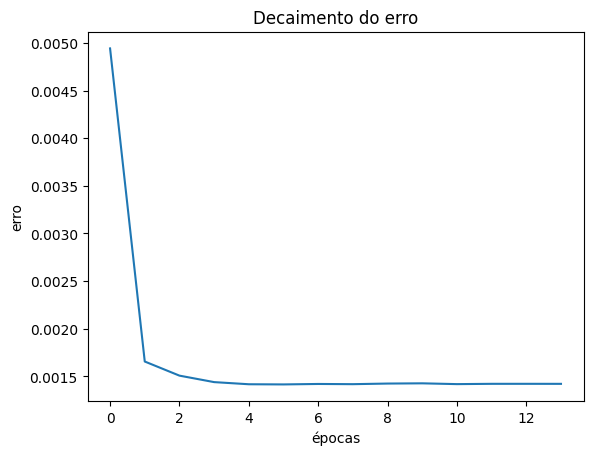

In [ ]:
#######Esta parte só funciona quando o solver é adam ou sgd

import matplotlib.pyplot as plt

plt.plot(ModeloRNA.loss_curve_)
plt.title('Decaimento do erro')
plt.xlabel('épocas')
plt.ylabel('erro')

In [ ]:
y_predictn = pd.DataFrame(ModeloRNA.predict(train_entn))  #Uso dos dados de entrada normalizados para predição pelo modelo.

#y_predictn

In [ ]:
#Desnormalização dos dados
y_predict = scaler2.inverse_transform(y_predictn) #Usando os valores máximos e mínimos definidos pelos vetores reais.
y_predict = np.ravel(y_predict)
print(pd.DataFrame(y_predict))

              0
0      2.146649
1      2.151870
2      2.152821
3      2.149121
4      2.141983
...         ...
57656  2.543227
57657  2.542791
57658  2.542215
57659  2.541918
57660  2.541724

[57661 rows x 1 columns]


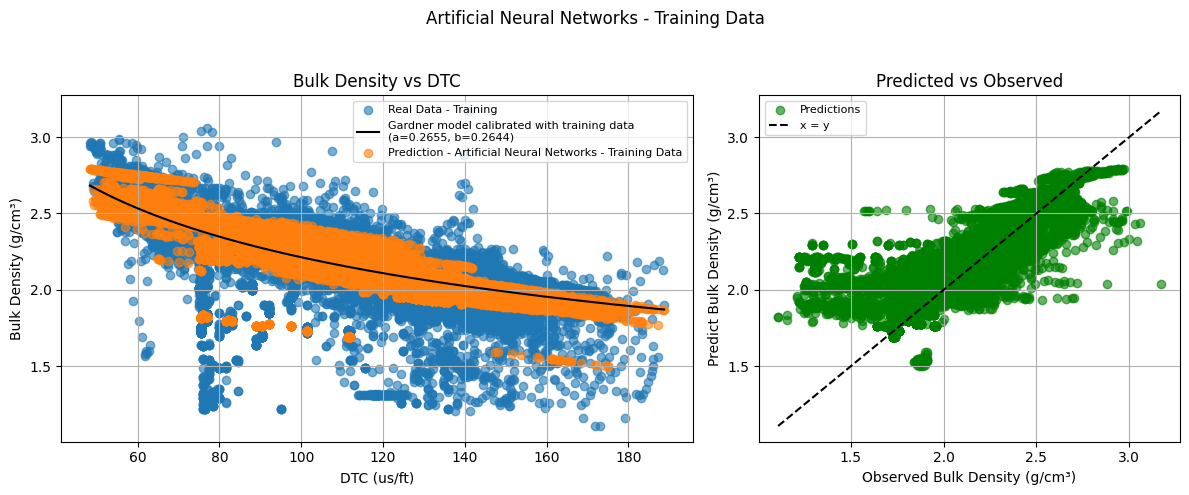

Metrics - Artificial Neural Networks - Training Data
R²: 0.7776
MSE: 0.0120
SSE: 689.6857


/tmp/ipython-input-224-1225550520.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_modelo[nome_coluna_predita] = y_predito


In [ ]:
df_train, met_rna_train = avaliar_modelo_regressao(y_predict, df_train, titulo= 'Artificial Neural Networks - Training Data', nome_modelo = "ANN", tipo_dado = "Training")

In [ ]:
#Pesos
Pesos = ModeloRNA.coefs_

Pesos

[array([[ 0.09054925, -0.06216091, -0.22011132, ..., -0.15519948,
         -0.2416203 , -0.02050489],
        [-0.11821585,  0.0926961 ,  0.1539826 , ...,  0.16991119,
         -0.00705112,  0.08850295],
        [ 0.00118817, -0.06512555, -0.04060452, ...,  0.00599466,
          0.03989684, -0.00136121],
        ...,
        [ 0.00053122,  0.04647032, -0.00456846, ...,  0.02016553,
          0.02311403, -0.00117096],
        [-0.00123072,  0.12061766, -0.02648152, ...,  0.07908679,
          0.00280497, -0.00819444],
        [ 0.00398815, -0.01647608, -0.00943049, ...,  0.0147881 ,
          0.01190962, -0.00039415]]),
 array([[-0.00456604],
        [ 0.09018754],
        [ 0.03235493],
        [-0.00173023],
        [-0.10453288],
        [ 0.12552693],
        [-0.04402445],
        [ 0.12684193],
        [-0.04691043],
        [ 0.05308148],
        [ 0.12110718],
        [-0.03502638],
        [ 0.08012806],
        [ 0.06241954],
        [ 0.01514714],
        [-0.10264955],
     

In [ ]:
#Bias
bias = ModeloRNA.intercepts_

bias

[array([-0.08562711,  0.11188108, -0.05771716,  0.08654944, -0.02048479,
        -0.03581003,  0.06132407, -0.11550203,  0.03337852, -0.03766439,
        -0.08497484,  0.04765534,  0.10435015,  0.0613255 ,  0.07773958,
         0.08205282, -0.07116777, -0.0090916 , -0.06288863, -0.0897445 ,
         0.10814791,  0.11153268,  0.09254399,  0.08663539,  0.01520377,
        -0.01515494, -0.01909151,  0.05575503,  0.13064149,  0.03709244,
        -0.10973464,  0.03515693, -0.11455314,  0.01533238,  0.0269738 ,
        -0.00132029,  0.10416991,  0.00016604, -0.06768276, -0.03698281,
         0.0618382 , -0.08510415, -0.08688253, -0.05641128,  0.06920501,
         0.05213644, -0.06473704,  0.01385964, -0.00268552, -0.04736046,
         0.02722306, -0.11081638, -0.08477563,  0.07654399, -0.03747867,
        -0.00123771, -0.0639755 ,  0.11084514,  0.02907376, -0.10485453,
         0.04612129,  0.10350402, -0.11236099,  0.02897263, -0.11024167,
        -0.07882358, -0.08200328,  0.08784268,  0.0

## **Teste 1**

In [ ]:
y_predict2n = pd.DataFrame(ModeloRNA.predict(test1_entn))
y_predict2n

0
0      0.452950
1      0.460012
2      0.466806
3      0.478840
4      0.481003
...         ...
13369  0.758208
13370  0.724291
13371  0.723962
13372  0.723768
13373  0.723690

[13374 rows x 1 columns]

In [ ]:
#Desnormalização dados de teste 1
y_predict2 = scaler2.inverse_transform(y_predict2n) #Usando o valores máximos e mínimos definidos pelos vetores reais.
y_predict2 = np.ravel(y_predict2)
print(pd.DataFrame(y_predict2))

              0
0      2.043078
1      2.057625
2      2.071620
3      2.096410
4      2.100866
...         ...
13369  2.671909
13370  2.602040
13371  2.601362
13372  2.600962
13373  2.600802

[13374 rows x 1 columns]


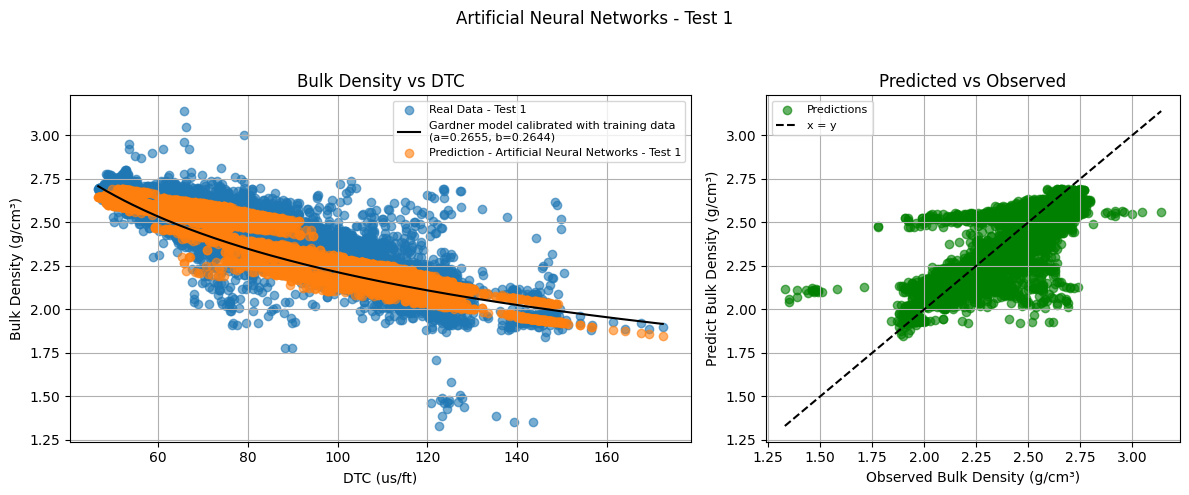

Metrics - Artificial Neural Networks - Test 1
R²: 0.8063
MSE: 0.0099
SSE: 132.1848


/tmp/ipython-input-224-1225550520.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_modelo[nome_coluna_predita] = y_predito


In [ ]:
df_test1, met_rna_test1 = avaliar_modelo_regressao(y_predict2, df_test1, titulo= 'Artificial Neural Networks - Test 1', nome_modelo = "ANN", tipo_dado = "Test 1")

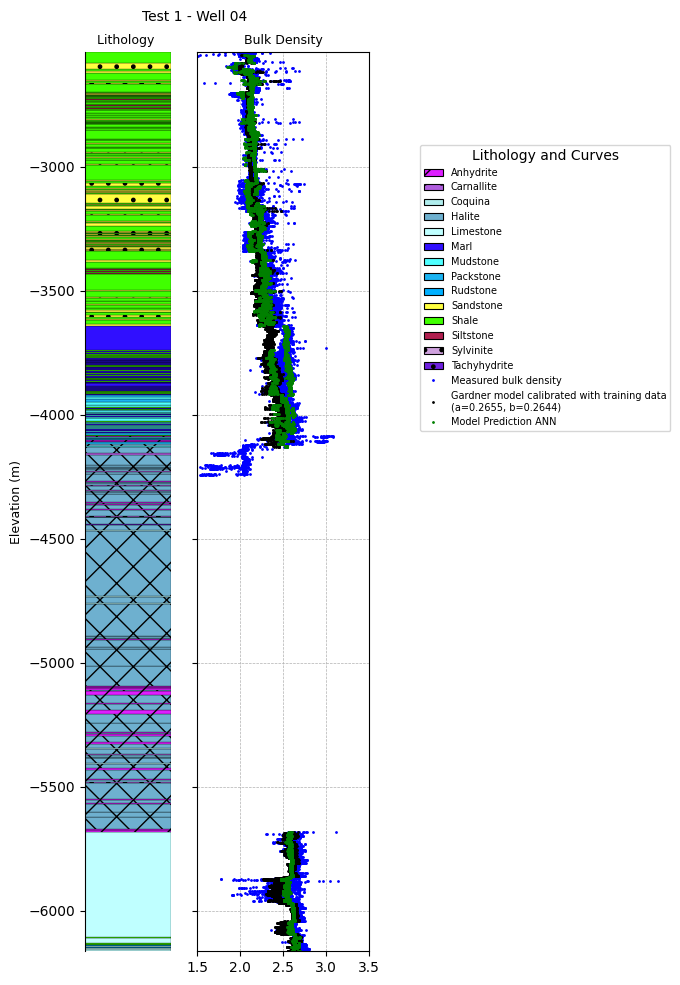

In [ ]:
dados_test1_RNA = {
    'Bulk Density': y_predict2,
    'Elevation': df_test1["Elevation"],
    'DTC': df_test1["DTC"],
    'titulo_grafico': 'Test 1 - Well 04',
    'legenda_modelo': 'ANN'
}

pocotest1 = df_test1['Well'].iloc[0]

plotar_litologia_e_densidade_Modelo(
    dataset_original[dataset_original['Well'] == pocotest1],
    dados_test1_RNA
)

## **Teste 2**

In [ ]:
y_final1predictn = pd.DataFrame(ModeloRNA.predict(test2_entn)) #RNA teve maior R2 com dados de teste 1
y_final1predictn

0
0     0.483683
1     0.483083
2     0.481186
3     0.480502
4     0.482750
...        ...
9802  0.705795
9803  0.705835
9804  0.705859
9805  0.705866
9806  0.705889

[9807 rows x 1 columns]

In [ ]:
#Desnormalização dados de teste 1
y_final1predict = scaler2.inverse_transform(y_final1predictn) #Usando o valores máximos e mínimos definidos pelos vetores reais.
y_final1predict = np.ravel(y_final1predict)
print(pd.DataFrame(y_final1predict))

             0
0     2.106386
1     2.105152
2     2.101244
3     2.099835
4     2.104464
...        ...
9802  2.563938
9803  2.564021
9804  2.564069
9805  2.564083
9806  2.564131

[9807 rows x 1 columns]


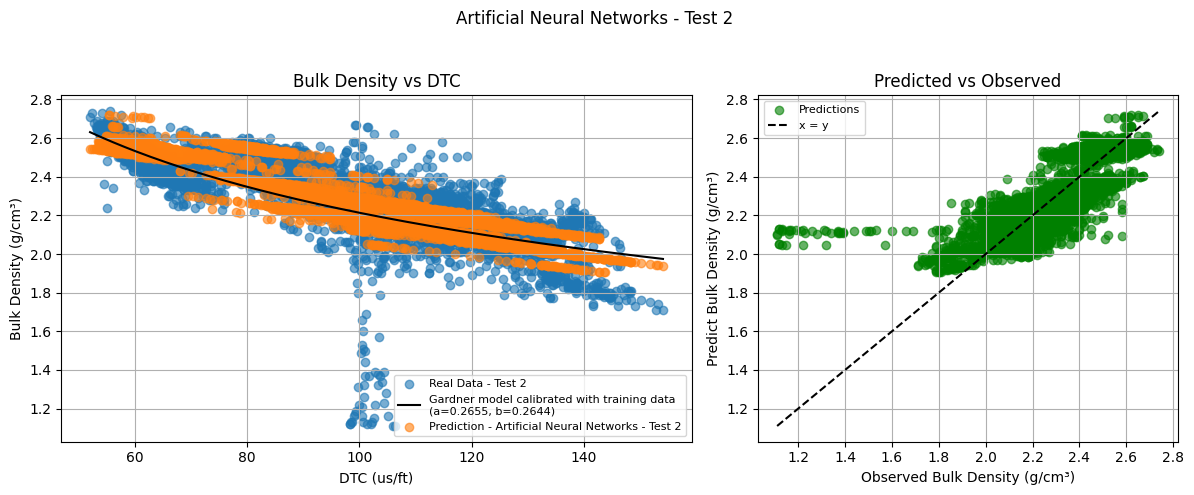

Metrics - Artificial Neural Networks - Test 2
R²: 0.7253
MSE: 0.0102
SSE: 100.4683


/tmp/ipython-input-224-1225550520.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_modelo[nome_coluna_predita] = y_predito


In [ ]:
df_test2, met_rna_test2 = avaliar_modelo_regressao(y_final1predict, df_test2, titulo= 'Artificial Neural Networks - Test 2', nome_modelo = "ANN", tipo_dado = "Test 2")

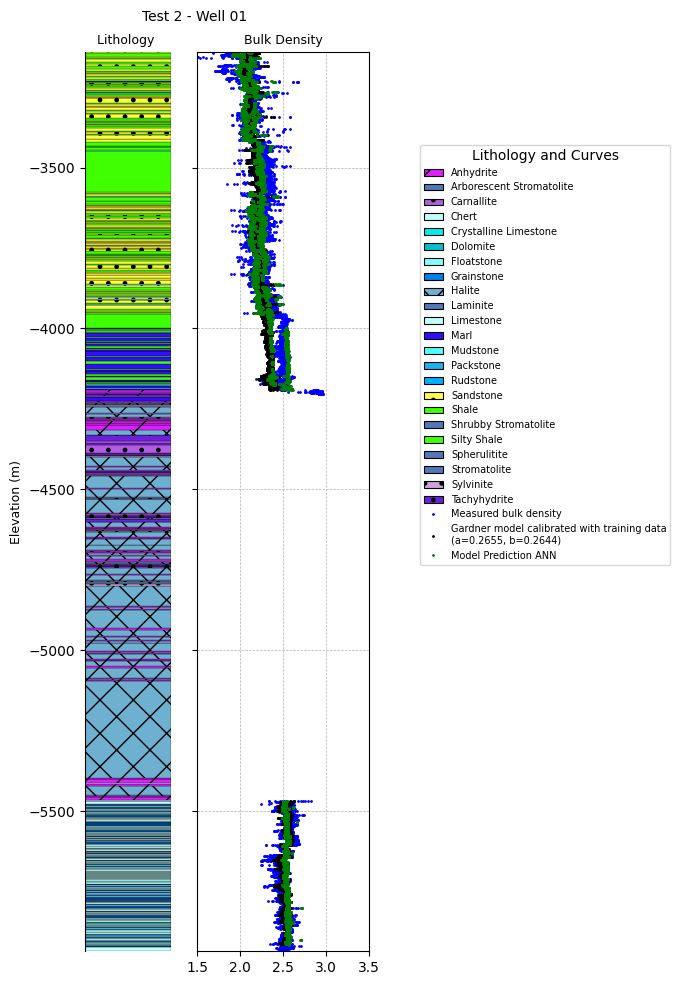

In [ ]:
dados_test2_RNA = {
    'Bulk Density': y_final1predict,
    'Elevation': df_test2["Elevation"],
    'DTC': df_test2["DTC"],
    'titulo_grafico': 'Test 2 - Well 01',
    'legenda_modelo': 'ANN'
}

pocotest2 = df_test2['Well'].iloc[0]

plotar_litologia_e_densidade_Modelo(
    dataset_original[dataset_original['Well'] == pocotest2],
    dados_test2_RNA
)

# **Comparação Final entre Modelos**

In [ ]:
tabela_resultadosfinal = pd.concat([
    met_rna_train, met_rna_test1, met_rna_test2,
    met_ad_train, met_ad_test1, met_ad_test2,
    met_svm_train, met_svm_test1, met_svm_test2,
    met_gardner_train, met_gardner_test1, met_gardner_test
    ], ignore_index=True)
display(tabela_resultadosfinal)

Model Data Type        R²       MSE          SSE
0       ANN  Training  0.777582  0.011961   689.685655
1       ANN    Test 1  0.806263  0.009884   132.184812
2       ANN    Test 2  0.725345  0.010245   100.468255
3        DT  Training  0.792225  0.011174   644.277750
4        DT    Test 1  0.668282  0.016923   226.328100
5        DT    Test 2  0.565181  0.016219   159.056000
6       SVR  Training  0.737579  0.014112   813.727000
7       SVR    Test 1  0.672491  0.016708   223.456417
8       SVR    Test 2  0.574032  0.015888   155.818449
9   Gardner  Training  0.665463  0.017990  1037.350145
10  Gardner    Test 1  0.725865  0.013985   187.040131
11  Gardner    Test 2  0.630576  0.013779   135.134905

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

def plotar_litologia_e_comparacao_modelos(df_poco, dados_modelos):
    """
    Gera um gráfico com múltiplos tracks para comparar os modelos de densidade com os dados reais.
    """
    df_poco = df_poco.copy()
    df_poco['Elevation'] = pd.to_numeric(df_poco['Elevation'], errors='coerce')
    df_poco = df_poco.dropna(subset=['Elevation'])

    intervalos = agrupar_intervalos(df_poco)
    nome_poco = df_poco['Well'].iloc[0]

    n_tracks = len(dados_modelos) + 1

    width_ratios = [0.5] + [1] * (n_tracks - 1)

    fig, axes = plt.subplots(
        1, n_tracks, figsize=(2 * n_tracks + 4, 10),
        sharey=True,
        gridspec_kw={'width_ratios': width_ratios}
    )

    if n_tracks == 2:
        axes = [axes[0], axes[1]]

    ax_litologia = axes[0]
    litologias_presentes = set()

    for top, base, lit in intervalos:
        if base <= top:
            continue
        props = litologias_dict.get(lit, {"cor": "#FFFFFF", "hatch": ""})
        rect = patches.Rectangle(
            (0, top), 1, base - top,
            facecolor=props["cor"],
            edgecolor='black',
            hatch=props["hatch"],
            linewidth=0.2
        )
        ax_litologia.add_patch(rect)
        litologias_presentes.add(lit)

    ax_litologia.set_xlim(0, 1)
    ax_litologia.set_ylim(df_poco['Elevation'].min(), df_poco['Elevation'].max())
    ax_litologia.set_title('Lithology', fontsize=9)

    # Mostrar rótulo e valores no eixo Y
    ax_litologia.set_ylabel('Elevation (m)', fontsize=9)
    ax_litologia.tick_params(axis='y', labelsize=8)
    ax_litologia.set_xticks([])
    ax_litologia.spines['top'].set_visible(False)
    ax_litologia.spines['right'].set_visible(False)
    ax_litologia.spines['bottom'].set_visible(False)

    # Para legenda final
    handles_curvas = []
    labels_curvas = []

    for i, dados_modelo in enumerate(dados_modelos):
        ax = axes[i + 1]
        densidade_modelo = dados_modelo['Bulk Density']
        cota_modelo = dados_modelo['Elevation']

        titulo_grafico = dados_modelo.get('titulo_grafico', 'Resultado da Regressão')
        legenda_modelo = dados_modelo.get('legenda_modelo', 'Modelo')

        p1 = ax.plot(df_poco['Bulk Density'], df_poco['Elevation'], color='blue', marker='.', linestyle='None',
                     markersize=2, label='Measured Bulk Density')
        p2 = ax.plot(densidade_modelo, cota_modelo, color='green', marker='.', linestyle='None',
                     markersize=2, label='Model')

        ax.set_xlim(1.5, 3.5)
        ax.set_title(legenda_modelo, fontsize=9)
        ax.grid(True, linestyle='--', linewidth=0.5)

        if i == len(dados_modelos) - 1:
            ax.tick_params(axis='y', labelsize=0)  # Oculta os valores do eixo Y nos últimos axes

        # Salva handles apenas uma vez
        if i == 0:
            handles_curvas.extend([p1[0], p2[0]])
            labels_curvas.extend(['Measured Bulk Density', 'Model'])

    # Legenda combinada (litologias + curvas)
    handles_lito = []
    for lit in sorted(litologias_presentes):
        props = litologias_dict.get(lit, {"cor": "#FFFFFF", "hatch": ""})
        patch = patches.Patch(
            facecolor=props["cor"],
            hatch=props["hatch"],
            edgecolor='black',
            label=lit,
            linewidth=0.8
        )
        handles_lito.append(patch)

    fig.legend(
        handles_lito + handles_curvas,
        [h.get_label() for h in handles_lito] + labels_curvas,
        loc='center left',
        bbox_to_anchor=(1.01, 0.5),
        fontsize=8,
        title='Lithologies and Curves'
    )

    fig.suptitle(f'Comparison of Predictive Models: {nome_poco}', fontsize=11)
    plt.tight_layout(rect=[0, 0, 0.99, 1])  # Deixa espaço para a legenda
    plt.show()



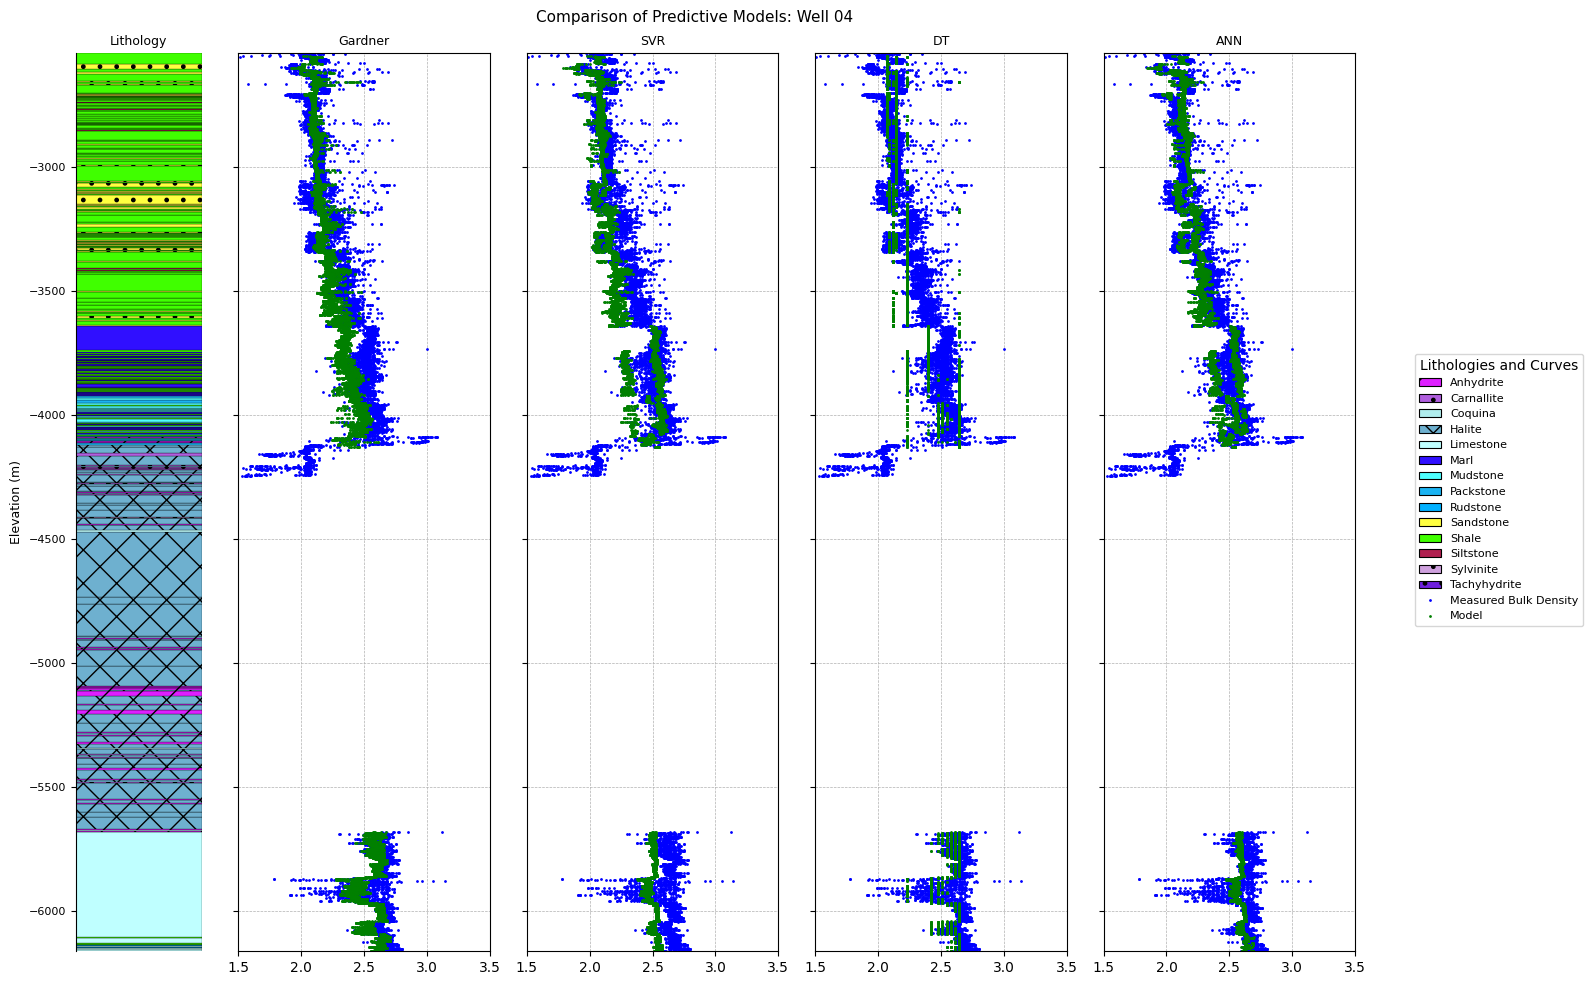

In [ ]:
dados_modelos_test1 = [
    dados_test1_Gardner,
    dados_test1_SVM,
    dados_test1_AD,
    dados_test1_RNA
]

pocotest1 = df_test1['Well'].iloc[0]

plotar_litologia_e_comparacao_modelos(dataset_original[dataset_original['Well'] == pocotest1], dados_modelos_test1)


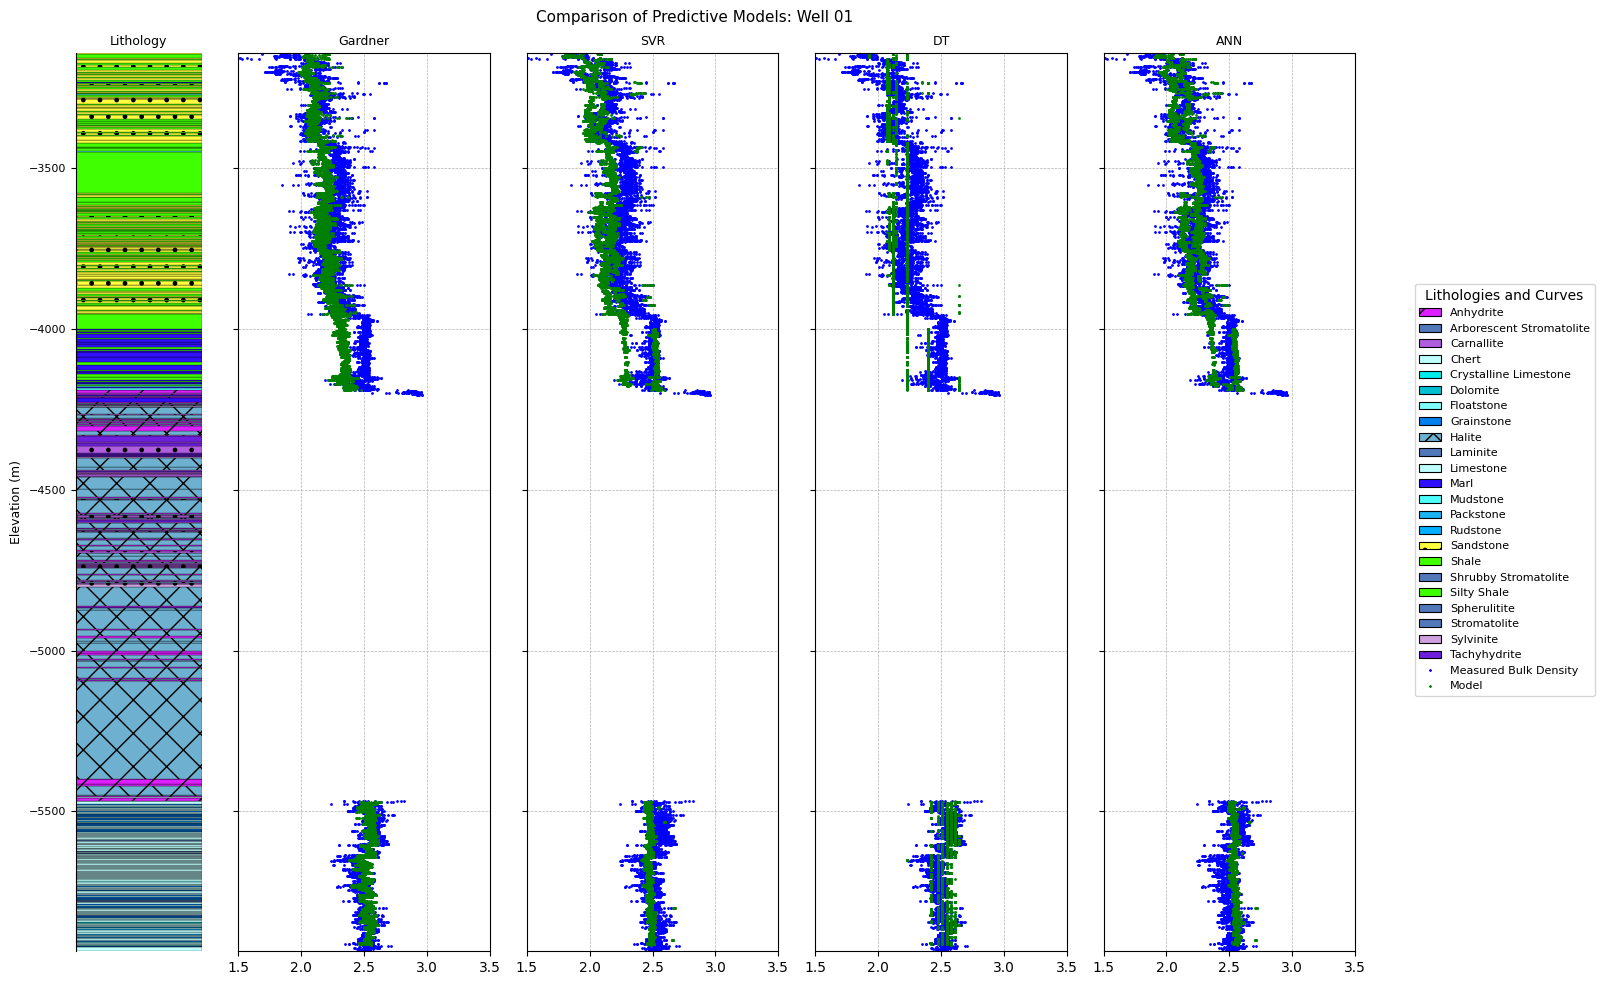

In [ ]:
dados_modelos_test2 = [
    dados_test2_Gardner,
    dados_test2_SVM,
    dados_test2_AD,
    dados_test2_RNA
]

pocotest2 = df_test2['Well'].iloc[0]


plotar_litologia_e_comparacao_modelos(dataset_original[dataset_original['Well'] == pocotest2], dados_modelos_test2)
